# Advanced Natural Language Processing Assignment 

# Propaganda Span Identification Task-1

In [ ]:
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
import math
import re

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Load Data

In [ ]:
# train_filename = "propaganda_train.tsv"
# test_filename = "propaganda_val.tsv"
train_filename = "/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda_train.tsv"
test_filename = "/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda_val.tsv"
train_df = pd.read_csv(train_filename, sep = '\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(test_filename, sep = '\t', quoting=csv.QUOTE_NONE)

In [ ]:
train_df.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [ ]:
test_df.head()

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


## Data Exploration

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              2560 non-null   object
 1   tagged_in_context  2560 non-null   object
dtypes: object(2)
memory usage: 40.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              640 non-null    object
 1   tagged_in_context  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [ ]:
train_df['label'].unique()

array(['not_propaganda', 'flag_waving', 'loaded_language', 'doubt',
       'name_calling,labeling', 'appeal_to_fear_prejudice', 'repetition',
       'causal_oversimplification', 'exaggeration,minimisation'],
      dtype=object)

In [ ]:
test_df['label'].unique()

array(['not_propaganda', 'causal_oversimplification',
       'appeal_to_fear_prejudice', 'repetition', 'name_calling,labeling',
       'loaded_language', 'flag_waving', 'doubt',
       'exaggeration,minimisation'], dtype=object)

In [ ]:
train_df1 = train_df.copy()

In [ ]:
test_df1 = test_df.copy()

In [ ]:
train_df1['labels'] = train_df1['label']

train_df1.head()

,label,tagged_in_context,labels
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",not_propaganda
1,not_propaganda,This declassification effort <BOS> won’t make ...,not_propaganda
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",flag_waving
3,not_propaganda,“It looks like we’re capturing the demise of t...,not_propaganda
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",not_propaganda


In [ ]:
train_df1.loc[train_df1['label'] != 'not_propaganda', 'labels'] = "propaganda"

In [ ]:
train_df1.head()

,label,tagged_in_context,labels
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",not_propaganda
1,not_propaganda,This declassification effort <BOS> won’t make ...,not_propaganda
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",propaganda
3,not_propaganda,“It looks like we’re capturing the demise of t...,not_propaganda
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",not_propaganda


In [ ]:
test_df1['labels'] = test_df1['label']
test_df1.loc[test_df1['label'] != 'not_propaganda', 'labels'] = "propaganda"

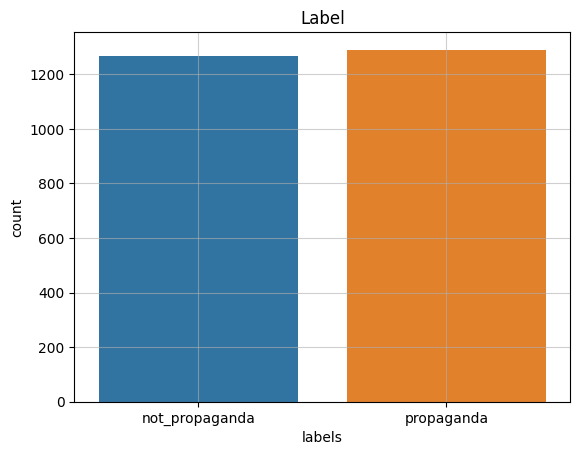

In [ ]:
# checking distribution of labels
sns.countplot(x="labels",data=train_df1)
plt.title("Label")
plt.grid(alpha = 0.6)

plt.show()

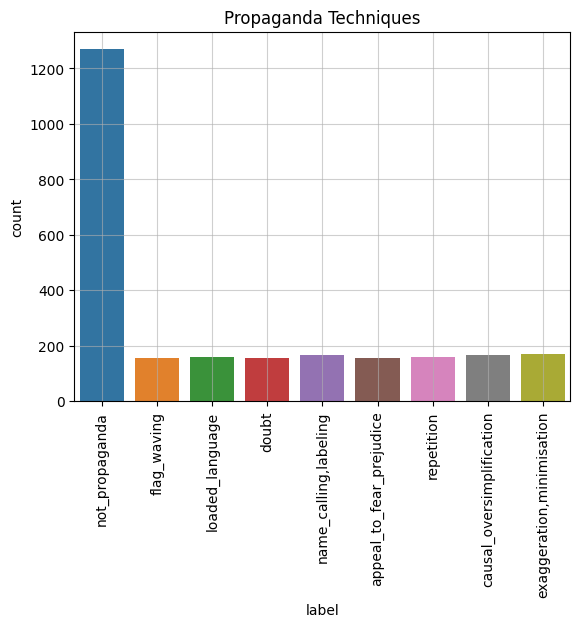

In [ ]:
# checking distribution of labels
sns.countplot(x="label",data=train_df1)
plt.title("Propaganda Techniques")
plt.grid(alpha = 0.6)
plt.xticks(rotation = 90)

plt.show()

In [ ]:
import re

sentences = [sent for sent in train_df1["tagged_in_context"]]
span_text = []
for sentence in sentences:
    try:
        text = re.search('<BOS>(.+?)<EOS>',sentence).group(1)
        span_text.append(text)
    except AttributeError:
        # <BOS>, <EOS> not found in the original string
        print("not found") # apply your error handling
        
span_text[:5]

[' he ',
 ' won’t make things any worse than they are for President Trump. ',
 ' American people ',
 ' and ',
 ' Location: Westerville, Ohio ']

In [ ]:
train_df1['span_text'] = span_text
train_df1.head()

,label,tagged_in_context,labels,span_text
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",not_propaganda,he
1,not_propaganda,This declassification effort <BOS> won’t make ...,not_propaganda,won’t make things any worse than they are for...
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",propaganda,American people
3,not_propaganda,“It looks like we’re capturing the demise of t...,not_propaganda,and
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",not_propaganda,"Location: Westerville, Ohio"


In [ ]:
from wordcloud import WordCloud

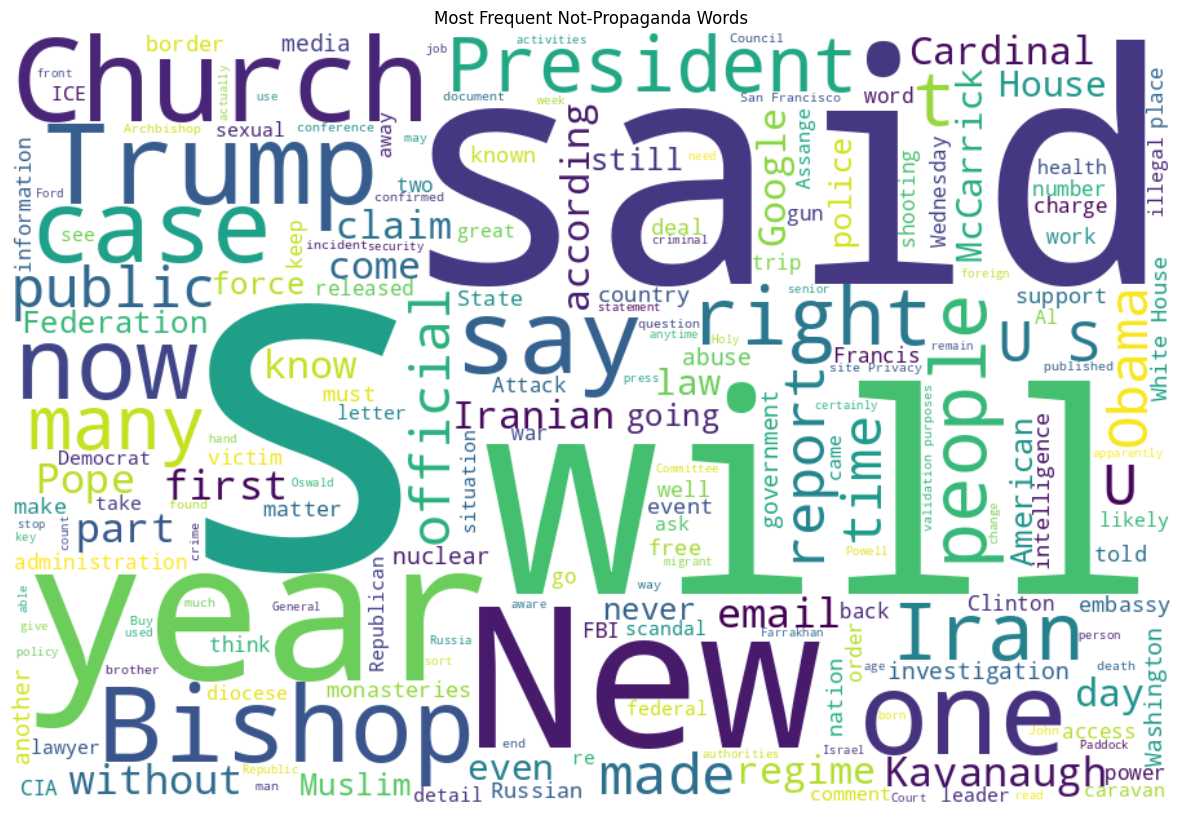

In [ ]:
# Plotting word cloud for not-propaganda text
not_prop = " ".join(train_df1[train_df1['labels'] == 'not_propaganda']['span_text'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white', random_state = 123).generate(not_prop)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequent Not-Propaganda Words")

# saving image file
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/not_propaganda_words.jpg', bbox_inches='tight', dpi = 300)

plt.show()

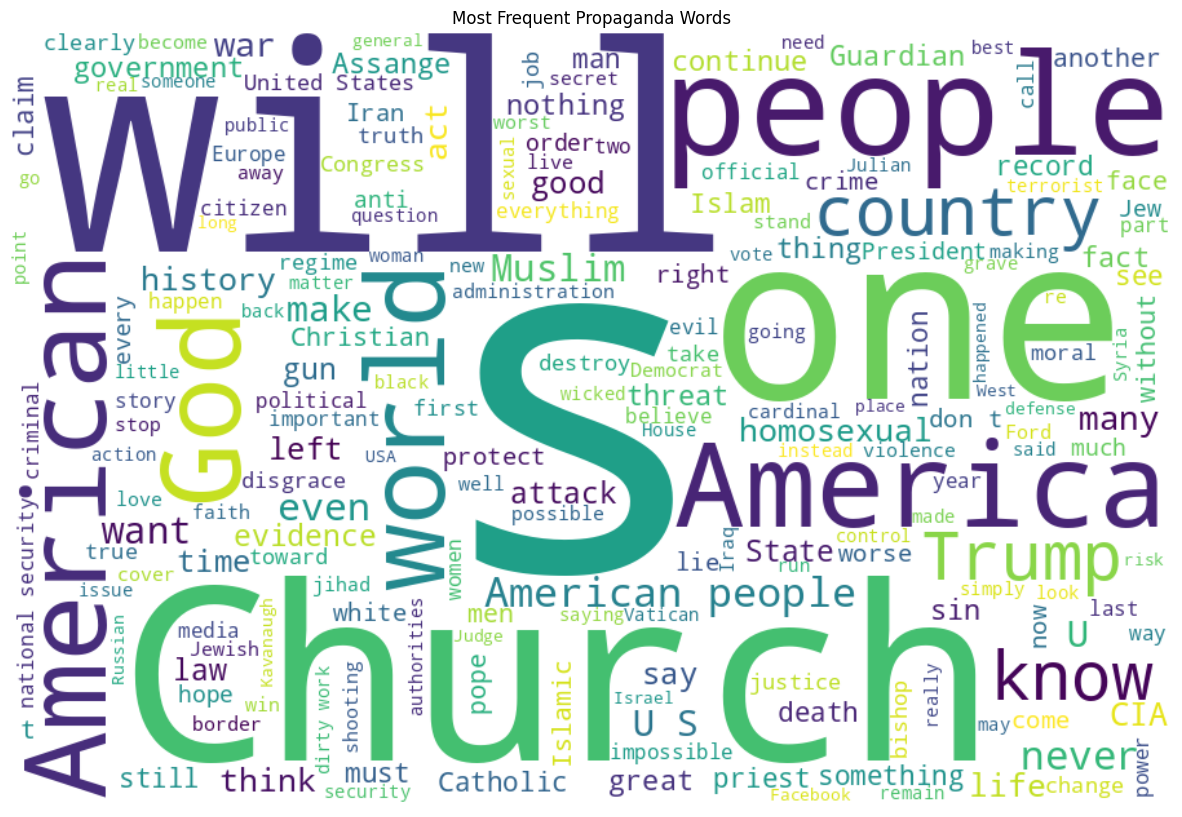

In [ ]:
# Plotting word cloud for propaganda text
prop = " ".join(train_df1[train_df1['labels'] != 'not_propaganda']['span_text'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white', random_state = 123).generate(prop)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequent Propaganda Words")

# saving image file
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda_words.jpg', bbox_inches='tight', dpi = 300)

plt.show()

## Data Pre-processing

**preprocessing steps**
* Convert sentences into lowercase.
* Remove punctuations ans special characters
* Remove `<BOS>` and `<EOS>` identifiers
* Remove stopwords
* Encoding labels into numerical form

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    black_list = ["bos", "eos"]
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS and word not in black_list) # delete stopwors from text 
    return text
    


In [ ]:
train_df1['tagged_in_context'] = train_df1['tagged_in_context'].apply(preprocess_text)
train_df1['tagged_in_context'][:5]

0                                            confirmed
1    declassification effort wont make things worse...
2    obama administration misled american people co...
3    looks like capturing demise dark vortex differ...
4                            location westerville ohio
Name: tagged_in_context, dtype: object

In [ ]:
train_df1['tagged_in_context'].apply(lambda x: len(x.split(' '))).sum()

35636

In [ ]:
test_df1['tagged_in_context'] = test_df1['tagged_in_context'].apply(preprocess_text)
test_df1['tagged_in_context'][:5]

0    average 300 600 infections recorded every year...
1    mostly country would last long without outside...
2    lyndon johnson gets earl warren sen richard ru...
3                                      may opt anytime
4    must exacted directly order vilify humiliate i...
Name: tagged_in_context, dtype: object

## Creating n-grams and Naive Bayes Classifier

In [ ]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]  #if word not in set(stopwords.words('english')) 
  # print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  result=[' '.join(ngram) for ngram in temp]
  return result

In [ ]:
# Generate Unigrams
not_propaganda = {}
propaganda = {}
#get the count of every word in both the columns of train_df and test_df dataframes where labels = "not_propaganda"
for text in train_df1[train_df1['labels']== 'not_propaganda'].tagged_in_context:
  for word in generate_N_grams(text):
    not_propaganda[word] = not_propaganda.get(word, 0) + 1

#get the count of every word in both the columns of train_df and test_df dataframes where labels = "propaganda"
for text in train_df1[train_df1['labels']== 'propaganda'].tagged_in_context:
  for word in generate_N_grams(text):
    propaganda[word] = propaganda.get(word, 0) + 1

In [ ]:
#focus on more frequently occuring words
#sort on second column(frequency/counts)

not_propaganda_df=pd.DataFrame(sorted(not_propaganda.items(),key=lambda x:x[1],reverse=True))
propaganda_df=pd.DataFrame(sorted(propaganda.items(),key=lambda x:x[1],reverse=True))

In [ ]:
not_propaganda_df.head()

,0,1
0,said,102
1,us,67
2,one,64
3,would,53
4,also,51


In [ ]:
propaganda_df.head()

,0,1
0,people,124
1,us,111
2,one,111
3,said,109
4,trump,102


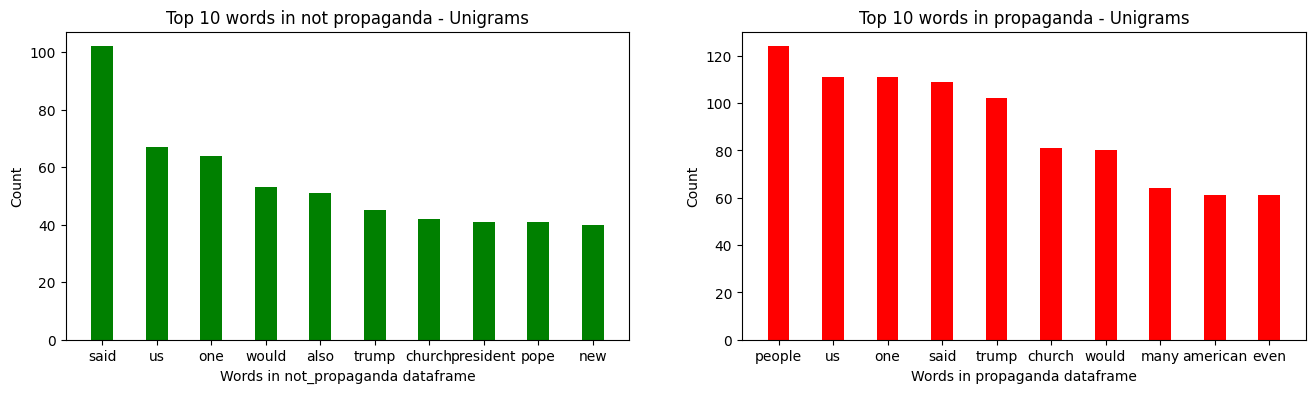

In [ ]:
npd_x = not_propaganda_df[0][:10]
npd_y = not_propaganda_df[1][:10]

pd_x=propaganda_df[0][:10]
pd_y=propaganda_df[1][:10]


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.bar(npd_x, npd_y, color ='green', width = 0.4)
ax1.set_xlabel("Words in not_propaganda dataframe")
ax1.set_ylabel("Count")
ax1.set_title("Top 10 words in not propaganda - Unigrams")
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/not_propaganda-unigram.png", bbox_inches = 'tight', dpi =300)

ax2.bar(pd_x, pd_y, color ='red', width = 0.4)
ax2.set_xlabel("Words in propaganda dataframe")
ax2.set_ylabel("Count")
ax2.set_title("Top 10 words in propaganda - Unigrams")
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda-unigram.png", bbox_inches = 'tight', dpi = 300)

plt.show()

### Create Bigrams

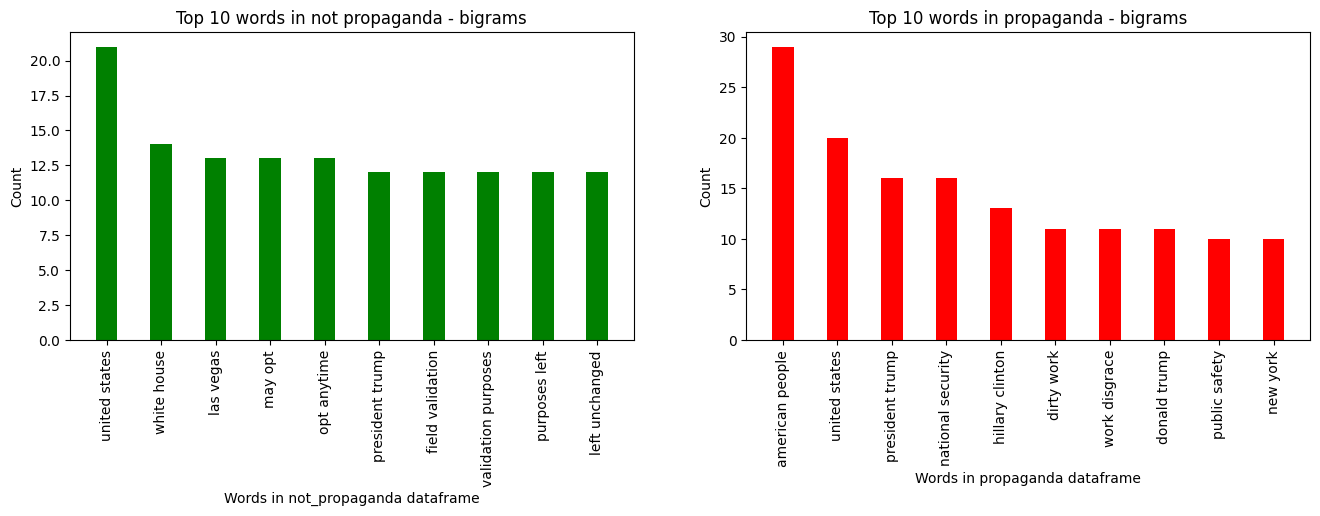

In [ ]:
# Generate Bi-grams
not_propaganda_bi = {}
propaganda_bi = {}
#get the count of every word in both the columns of train_df and test_df dataframes where labels = "not_propaganda"
for text in train_df1[train_df1['labels']== 'not_propaganda'].tagged_in_context:
  for word in generate_N_grams(text, 2):
    not_propaganda_bi[word] = not_propaganda_bi.get(word, 0) + 1

#get the count of every word in both the columns of train_df and test_df dataframes where labels = "propaganda"
for text in train_df1[train_df1['labels']== 'propaganda'].tagged_in_context:
  for word in generate_N_grams(text, 2):
    propaganda_bi[word] = propaganda_bi.get(word, 0) + 1

not_propaganda_df1 = pd.DataFrame(sorted(not_propaganda_bi.items(),key=lambda x:x[1],reverse=True))
propaganda_df1 = pd.DataFrame(sorted(propaganda_bi.items(),key=lambda x:x[1],reverse=True))

# Plotting bigrams
npd_x = not_propaganda_df1[0][:10]
npd_y = not_propaganda_df1[1][:10]

pd_x=propaganda_df1[0][:10]
pd_y=propaganda_df1[1][:10]


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.bar(npd_x, npd_y, color ='green', width = 0.4)
ax1.set_xlabel("Words in not_propaganda dataframe")
ax1.set_ylabel("Count")
ax1.set_xticklabels(labels = npd_x, rotation = 90)
ax1.set_title("Top 10 words in not propaganda - bigrams")
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/not_propaganda-bigram.png", bbox_inches = 'tight', dpi = 300)

ax2.bar(pd_x, pd_y, color ='red', width = 0.4)
ax2.set_xlabel("Words in propaganda dataframe")
ax2.set_ylabel("Count")
ax2.set_xticklabels(labels = pd_x, rotation = 90)
ax2.set_title("Top 10 words in propaganda - bigrams")
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda-bigram.png", bbox_inches = 'tight', dpi = 300)

plt.show()

### Create Trigrams

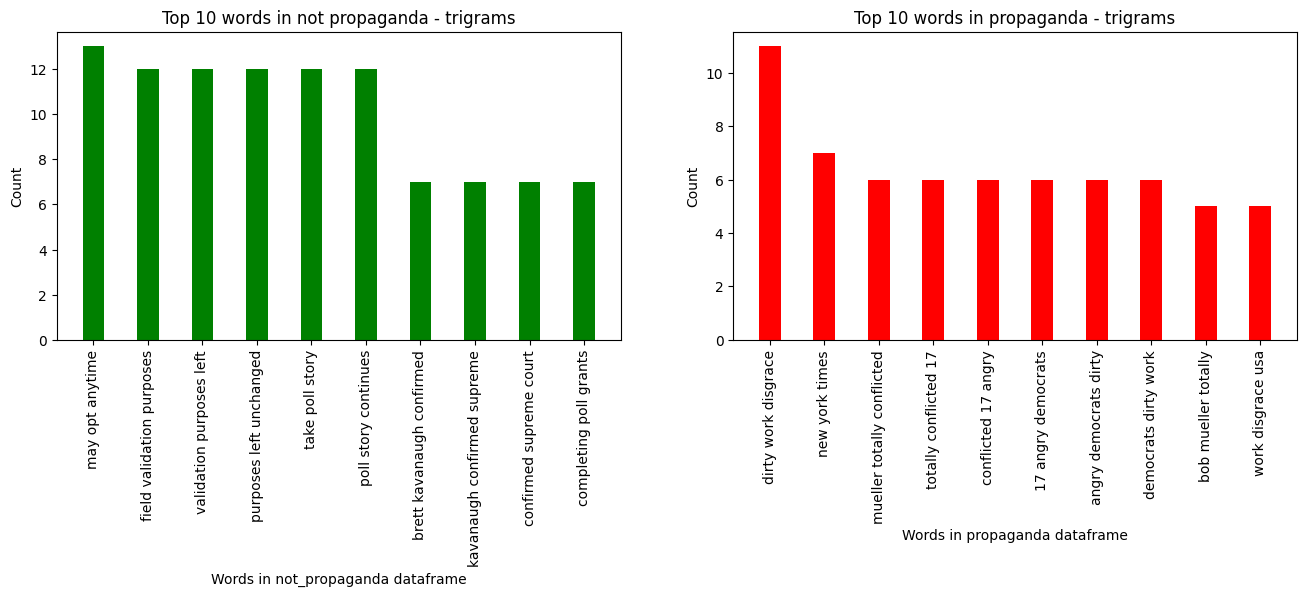

In [ ]:
# Generate Tri-grams
not_propaganda_tri = {}
propaganda_tri = {}
#get the count of every word in both the columns of train_df and test_df dataframes where labels = "not_propaganda"
for text in train_df1[train_df1['labels']== 'not_propaganda'].tagged_in_context:
  for word in generate_N_grams(text, 3):
    not_propaganda_tri[word] = not_propaganda_tri.get(word, 0) + 1

#get the count of every word in both the columns of train_df and test_df dataframes where labels = "propaganda"
for text in train_df1[train_df1['labels']== 'propaganda'].tagged_in_context:
  for word in generate_N_grams(text, 3):
    propaganda_tri[word] = propaganda_tri.get(word, 0) + 1

not_propaganda_df2 = pd.DataFrame(sorted(not_propaganda_tri.items(),key=lambda x:x[1],reverse=True))
propaganda_df2 = pd.DataFrame(sorted(propaganda_tri.items(),key=lambda x:x[1],reverse=True))

# Plotting bigrams
npd_x = not_propaganda_df2[0][:10]
npd_y = not_propaganda_df2[1][:10]

pd_x=propaganda_df2[0][:10]
pd_y=propaganda_df2[1][:10]


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.bar(npd_x, npd_y, color ='green', width = 0.4)
ax1.set_xlabel("Words in not_propaganda dataframe")
ax1.set_ylabel("Count")
ax1.set_xticklabels(labels = npd_x, rotation = 90)
ax1.set_title("Top 10 words in not propaganda - trigrams")
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/not_propaganda-trigram.jpg", dpi = 300)

ax2.bar(pd_x, pd_y, color ='red', width = 0.4)
ax2.set_xlabel("Words in propaganda dataframe")
ax2.set_ylabel("Count")
ax2.set_xticklabels(labels = pd_x, rotation = 90)
ax2.set_title("Top 10 words in propaganda - trigrams")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda-trigram.jpg",  bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

In [ ]:
def create_ngram_features(words, n=1):
    my_dict = {}
    for word in generate_N_grams(words, n):
      my_dict[word] = my_dict.get(word, 0) + 1 
    return my_dict

for n in [1,2,3,4,5]:
    not_propaganda_data = []
    for text in train_df1[train_df1['labels']== 'not_propaganda'].tagged_in_context:
        # sents = train_df1.tagged_in_context(label)
        not_propaganda_data.append((create_ngram_features(text, n), "not_propaganda"))    

    propaganda_data = []
    for text in train_df1[train_df1['labels']== 'propaganda'].tagged_in_context:
        # sents = train_df1.tagged_in_context(label)
        propaganda_data.append((create_ngram_features(text, n), "propaganda")) 

    test_not_propaganda_data = []
    for text in test_df1[test_df1['labels']== 'not_propaganda'].tagged_in_context:
        # sents = test_df1.tagged_in_context(label)
        test_not_propaganda_data.append((create_ngram_features(text, n), "not_propaganda"))    

    test_propaganda_data = []
    for text in test_df1[test_df1['labels']== 'propaganda'].tagged_in_context:
        # sents = test_df1.tagged_in_context(label)
        test_propaganda_data.append((create_ngram_features(text, n), "propaganda"))

    train_set = not_propaganda_data + propaganda_data
    test_set =  test_not_propaganda_data + test_propaganda_data
    # print(train_set[:5])
    # print(test_set[:5])
    sents,label = zip(*test_set)

    classifier = NaiveBayesClassifier.train(train_set)

    predictions = classifier.classify_many(sents)

    accuracy = nltk.classify.util.accuracy(classifier, test_set)
    print(str(n)+'-gram accuracy:', accuracy)
    print(str(n)+'-gram f1 score: %s' % f1_score(label, predictions, average='weighted'))

1-gram accuracy: 0.6453125
1-gram f1 score: 0.6213581941137386
2-gram accuracy: 0.575
2-gram f1 score: 0.5481526408505115
3-gram accuracy: 0.5359375
3-gram f1 score: 0.44748511687048725
4-gram accuracy: 0.5140625
4-gram f1 score: 0.3867717712762245
5-gram accuracy: 0.503125
5-gram f1 score: 0.36266117544768384


As we can see that unigram model is giving more accuracy ans f1-score than other n-grams.

## Modelling

In [ ]:
# Convert propaganda and not-propaganda labels to 1 and 0 (or, vice-versa)
FactorResult = pd.factorize(train_df1["labels"])
train_df1["labels"] = FactorResult[0]
train_df1.head()

,label,tagged_in_context,labels,span_text
0,not_propaganda,confirmed,0,he
1,not_propaganda,declassification effort wont make things worse...,0,won’t make things any worse than they are for...
2,flag_waving,obama administration misled american people co...,1,American people
3,not_propaganda,looks like capturing demise dark vortex differ...,0,and
4,not_propaganda,location westerville ohio,0,"Location: Westerville, Ohio"


In [ ]:
# Convert propaganda and not-propaganda labels to 1 and 0 (or, vice-versa)
FactorResult = pd.factorize(test_df1["labels"])
test_df1["labels"] = FactorResult[0]
test_df1.head()

,label,tagged_in_context,labels
0,not_propaganda,average 300 600 infections recorded every year...,0
1,causal_oversimplification,mostly country would last long without outside...,1
2,appeal_to_fear_prejudice,lyndon johnson gets earl warren sen richard ru...,1
3,not_propaganda,may opt anytime,0
4,repetition,must exacted directly order vilify humiliate i...,1


In [ ]:
train_sentences = train_df1['tagged_in_context']
train_label = train_df1['labels']

test_sentences = test_df1['tagged_in_context']
test_label = test_df1['labels']

In [ ]:
# Install xgboost library
! pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_auc_score

# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers
# import keras


In [ ]:
# MultinomialNB Classifier
labels = ["Not-Propaganda", "Propaganda"]

nb = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_sentences, train_label)
predictions_nb = nb.predict(test_sentences)

# calculating accuracy and f1 score
acc_nb = accuracy_score(predictions_nb, test_label)
f1_nb = f1_score(test_label, predictions_nb, average='macro')

print('accuracy: %s' % acc_nb)
print(classification_report(test_label, predictions_nb, target_names=labels))
print('f1 score: %s' % f1_nb)

accuracy: 0.6921875
                precision    recall  f1-score   support

Not-Propaganda       0.78      0.57      0.66       331
    Propaganda       0.64      0.83      0.72       309

      accuracy                           0.69       640
     macro avg       0.71      0.70      0.69       640
  weighted avg       0.71      0.69      0.69       640

f1 score: 0.6887766562744532


In [ ]:
accuracy, f1 = [], []
accuracy.append(acc_nb)
f1.append(f1_nb)

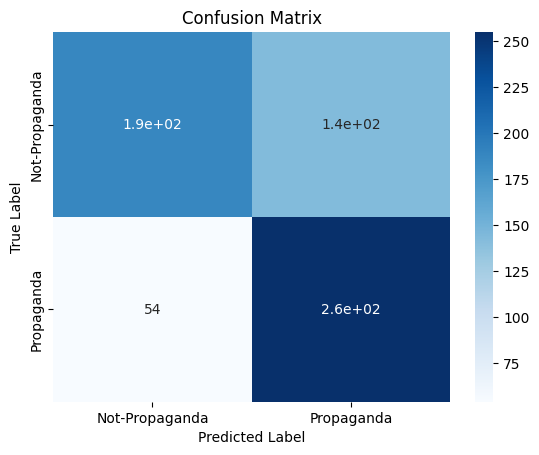

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(test_label, predictions_nb).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Implementing Logistic Regression
logreg = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))), #('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed)),
               ])
logreg.fit(train_sentences, train_label)

predictions_logreg = logreg.predict(test_sentences)

# calculating accuracy and f1 score
acc_lr = accuracy_score(predictions_logreg, test_label)
f1_lr = f1_score(test_label, predictions_logreg, average='macro')

accuracy.append(acc_lr)
f1.append(f1_lr)

print('accuracy: %s' % acc_lr)
print(classification_report(test_label, predictions_logreg, target_names=labels))
print('f1 score: %s' % f1_lr)

accuracy: 0.6984375
                precision    recall  f1-score   support

Not-Propaganda       0.72      0.69      0.70       331
    Propaganda       0.68      0.71      0.70       309

      accuracy                           0.70       640
     macro avg       0.70      0.70      0.70       640
  weighted avg       0.70      0.70      0.70       640

f1 score: 0.698401420091759


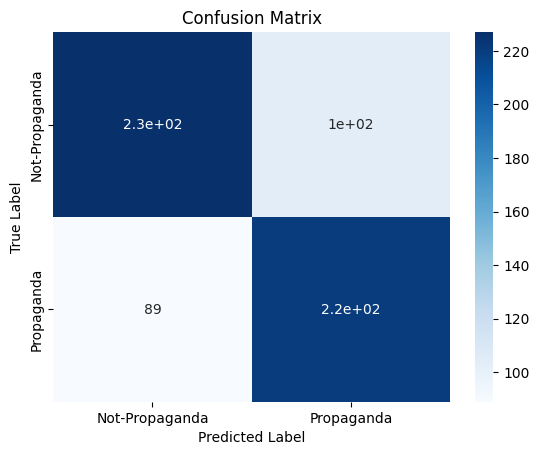

In [ ]:
# Plotting a confusion matrix
cm_logreg = confusion_matrix(test_label, predictions_logreg).astype(int)
sns.heatmap(cm_logreg, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=random_seed, max_iter=5, tol=None)),
               ])
sgd.fit(train_sentences, train_label)

predictions_sgd = sgd.predict(test_sentences)

# calculating accuracy and f1 score
acc_sgd = accuracy_score(predictions_sgd, test_label)
f1_sgd = f1_score(test_label, predictions_sgd, average='macro')

accuracy.append(acc_sgd)
f1.append(f1_sgd)

print('accuracy: %s' % acc_sgd)
print(classification_report(test_label, predictions_sgd, target_names=labels))
print('f1 score: %s' % f1_sgd)

accuracy: 0.69375
                precision    recall  f1-score   support

Not-Propaganda       0.71      0.70      0.70       331
    Propaganda       0.68      0.69      0.68       309

      accuracy                           0.69       640
     macro avg       0.69      0.69      0.69       640
  weighted avg       0.69      0.69      0.69       640

f1 score: 0.6935075596907709


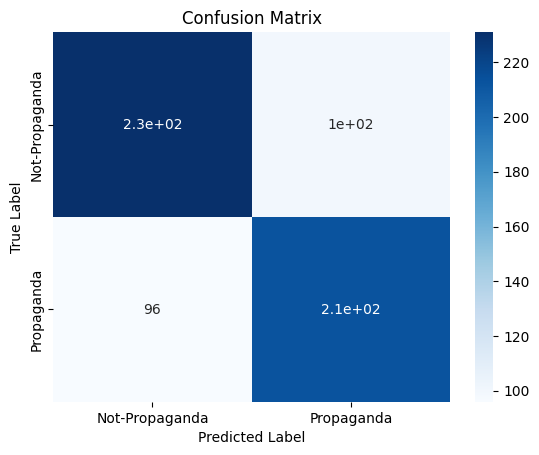

In [ ]:
# Plotting a confusion matrix
cm_sgd = confusion_matrix(test_label, predictions_sgd).astype(int)
sns.heatmap(cm_sgd, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Train an xgboost classifier
xgbc = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
                ('clf', XGBClassifier(random_state = random_seed)),
               ])
xgbc.fit(train_sentences, train_label)

predictions_xgbc = xgbc.predict(test_sentences)

# calculating accuracy and f1 score
acc_xgb = accuracy_score(predictions_xgbc, test_label)
f1_xgb = f1_score(test_label, predictions_xgbc, average='macro')

accuracy.append(acc_xgb)
f1.append(f1_xgb)

print('accuracy: %s' % acc_xgb)
print(classification_report(test_label, predictions_xgbc, target_names=labels))
print('f1 score: %s' % f1_xgb)

accuracy: 0.6859375
                precision    recall  f1-score   support

Not-Propaganda       0.68      0.75      0.71       331
    Propaganda       0.70      0.62      0.66       309

      accuracy                           0.69       640
     macro avg       0.69      0.68      0.68       640
  weighted avg       0.69      0.69      0.68       640

f1 score: 0.6836008116583656


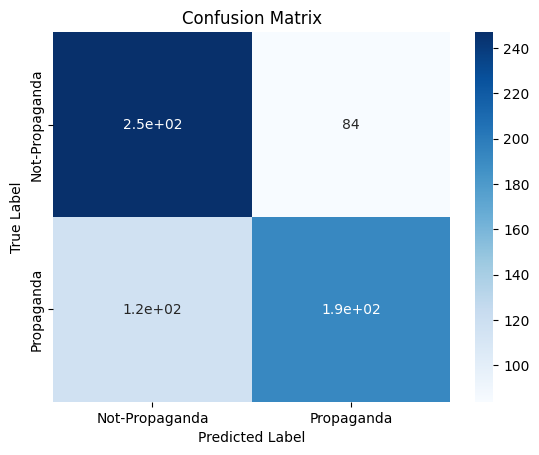

In [ ]:
# Plotting a confusion matrix
cm_xgbc = confusion_matrix(test_label, predictions_xgbc).astype(int)
sns.heatmap(cm_xgbc, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
models = ['MultinomialNB', 'Logistic Regression', 'SGD Classifier', 'XGBoost Classifier']
matrics_dict = {'Accuracy': accuracy, 'F1-Score': f1}  # 'Models': model, 

model_df = pd.DataFrame(matrics_dict.values(), columns = models).T
model_df.columns = ['Accuracy', 'F1-score']
model_df = model_df.sort_values(by = ['F1-score'], ascending = False)   # sort value according to highest f1-score 
model_df

,Accuracy,F1-score
Logistic Regression,0.698438,0.698401
SGD Classifier,0.693750,0.693508
MultinomialNB,0.692187,0.688777
XGBoost Classifier,0.685937,0.683601


## Without Removing stop words

In [ ]:
import nltk 
from nltk import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')
from nltk import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))

def preprocess_text1(text):
    black_list = ["bos", "eos"]
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in black_list) 
    return text
  

In [ ]:
train_df2 = train_df.copy()
train_df2['tagged_in_context'] = train_df2['tagged_in_context'].apply(preprocess_text1)
train_df2.head()

,label,tagged_in_context
0,not_propaganda,no he will not be confirmed
1,not_propaganda,this declassification effort wont make things ...
2,flag_waving,the obama administration misled the american p...
3,not_propaganda,it looks like were capturing the demise of thi...
4,not_propaganda,location westerville ohio


In [ ]:
train_df2['labels'] = train_df2['label']
train_df2.loc[train_df2['label'] != 'not_propaganda', 'labels'] = "propaganda"
train_df2.head()

,label,tagged_in_context,labels
0,not_propaganda,no he will not be confirmed,not_propaganda
1,not_propaganda,this declassification effort wont make things ...,not_propaganda
2,flag_waving,the obama administration misled the american p...,propaganda
3,not_propaganda,it looks like were capturing the demise of thi...,not_propaganda
4,not_propaganda,location westerville ohio,not_propaganda


In [ ]:
test_df2 = test_df.copy()
test_df2['tagged_in_context'] = test_df2['tagged_in_context'].apply(preprocess_text1)
test_df2['labels'] = test_df2['label']
test_df2.loc[test_df2['label'] != 'not_propaganda', 'labels'] = "propaganda"
test_df2.head()

,label,tagged_in_context,labels
0,not_propaganda,on average between 300 and 600 infections are ...,not_propaganda
1,causal_oversimplification,mostly because the country would not last long...,propaganda
2,appeal_to_fear_prejudice,lyndon johnson gets earl warren and sen richar...,propaganda
3,not_propaganda,you may opt out at anytime,not_propaganda
4,repetition,it must be exacted from him directly in order ...,propaganda


In [ ]:
# Convert propaganda and not-propaganda labels to 1 and 0 (or, vice-versa)
FactorResult = pd.factorize(train_df2["labels"])
train_df2["labels"] = FactorResult[0]
train_df2.head()

,label,tagged_in_context,labels
0,not_propaganda,no he will not be confirmed,0
1,not_propaganda,this declassification effort wont make things ...,0
2,flag_waving,the obama administration misled the american p...,1
3,not_propaganda,it looks like were capturing the demise of thi...,0
4,not_propaganda,location westerville ohio,0


In [ ]:
# Convert propaganda and not-propaganda labels to 1 and 0 (or, vice-versa)
FactorResult = pd.factorize(test_df2["labels"])
test_df2["labels"] = FactorResult[0]
test_df2.head()

,label,tagged_in_context,labels
0,not_propaganda,on average between 300 and 600 infections are ...,0
1,causal_oversimplification,mostly because the country would not last long...,1
2,appeal_to_fear_prejudice,lyndon johnson gets earl warren and sen richar...,1
3,not_propaganda,you may opt out at anytime,0
4,repetition,it must be exacted from him directly in order ...,1


In [ ]:
train_sentences2 = train_df2['tagged_in_context']
train_label2 = train_df2['labels']

test_sentences2 = test_df2['tagged_in_context']
test_label2 = test_df2['labels']

### Models

In [ ]:
# implementing MultinomialNB
labels = ["Not-Propaganda", "Propaganda"]
nb = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_sentences2, train_label2)
predictions_nb2 = nb.predict(test_sentences2)

# calculating accuracy and f1 score
acc_nb2 = accuracy_score(predictions_nb2, test_label2)
f1_nb2 = f1_score(test_label2, predictions_nb2, average='macro')

print('accuracy: %s' % acc_nb2)
print(classification_report(test_label2, predictions_nb2, target_names=labels))
print('f1 score: %s' % f1_nb2)

accuracy: 0.678125
                precision    recall  f1-score   support

Not-Propaganda       0.81      0.49      0.61       331
    Propaganda       0.62      0.88      0.72       309

      accuracy                           0.68       640
     macro avg       0.71      0.68      0.67       640
  weighted avg       0.72      0.68      0.67       640

f1 score: 0.6686904426842508


In [ ]:
accuracy2, f1_2 = [], []
accuracy2.append(acc_nb2)
f1_2.append(f1_nb2)

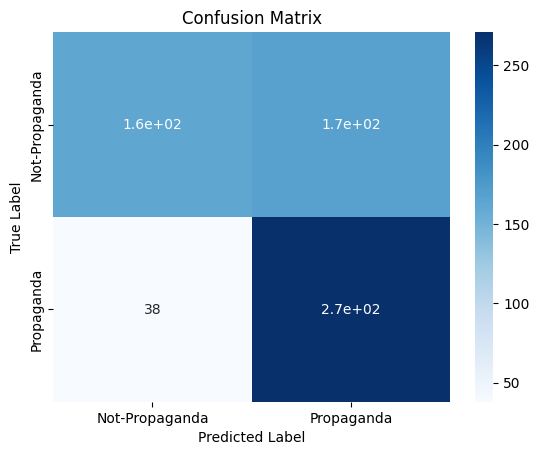

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(test_label2, predictions_nb2).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Implementing Logistic Regression
logreg = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))), 
                ('clf', LogisticRegression(solver='lbfgs', multi_class='auto', random_state = random_seed)),
               ])
logreg.fit(train_sentences2, train_label2)

predictions_logreg2 = logreg.predict(test_sentences2)

# calculating accuracy and f1 score
acc_lr2 = accuracy_score(predictions_logreg2, test_label2)
f1_lr2 = f1_score(test_label2, predictions_logreg2, average='macro')

accuracy2.append(acc_lr2)
f1_2.append(f1_lr2)

print('accuracy: %s' % acc_lr2)
print(classification_report(test_label2, predictions_logreg2, target_names=labels))
print('f1 score: %s' % f1_lr2)

accuracy: 0.7140625
                precision    recall  f1-score   support

Not-Propaganda       0.74      0.68      0.71       331
    Propaganda       0.69      0.75      0.72       309

      accuracy                           0.71       640
     macro avg       0.72      0.72      0.71       640
  weighted avg       0.72      0.71      0.71       640

f1 score: 0.7140450466947446


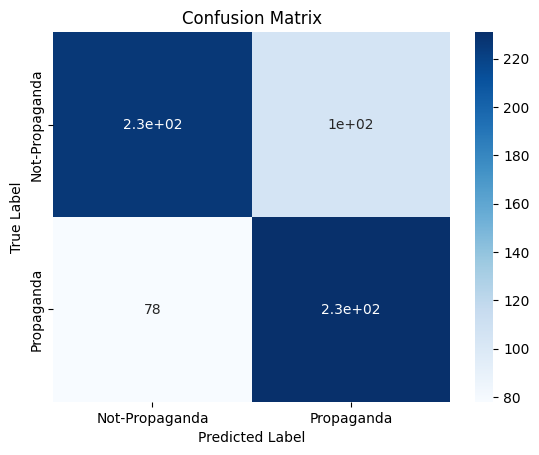

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(test_label2, predictions_logreg2).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# SGD Classifier
sgd = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=random_seed, max_iter=5, tol=None)),
               ])
sgd.fit(train_sentences2, train_label2)

predictions_sgd2 = sgd.predict(test_sentences2)

# calculating accuracy and f1 score
acc_sgd2 = accuracy_score(predictions_sgd2, test_label2)
f1_sgd2 = f1_score(test_label2, predictions_sgd2, average='macro')

accuracy2.append(acc_sgd2)
f1_2.append(f1_sgd2)

print('accuracy: %s' % acc_sgd2)
print(classification_report(test_label2, predictions_sgd2, target_names=labels))
print('f1 score: %s' % f1_sgd2)

accuracy: 0.715625
                precision    recall  f1-score   support

Not-Propaganda       0.74      0.70      0.72       331
    Propaganda       0.70      0.73      0.71       309

      accuracy                           0.72       640
     macro avg       0.72      0.72      0.72       640
  weighted avg       0.72      0.72      0.72       640

f1 score: 0.715580559462416


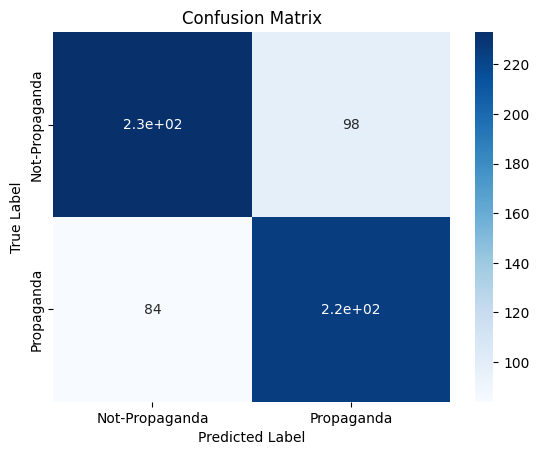

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(test_label2, predictions_sgd2).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Train an xgboost classifier
xgbc = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
                ('clf', XGBClassifier(random_state = random_seed)),
               ])
xgbc.fit(train_sentences2, train_label2)

predictions_xgbc2 = xgbc.predict(test_sentences2)

# calculating accuracy and f1 score
acc_xgb2 = accuracy_score(predictions_xgbc2, test_label2)
f1_xgb2 = f1_score(test_label2, predictions_xgbc2, average='macro')

accuracy2.append(acc_xgb2)
f1_2.append(f1_xgb2)

print('accuracy: %s' % acc_xgb2)
print(classification_report(test_label2, predictions_xgbc2, target_names=labels))
print('f1 score: %s' % f1_xgb2)

accuracy: 0.6796875
                precision    recall  f1-score   support

Not-Propaganda       0.68      0.73      0.70       331
    Propaganda       0.68      0.62      0.65       309

      accuracy                           0.68       640
     macro avg       0.68      0.68      0.68       640
  weighted avg       0.68      0.68      0.68       640

f1 score: 0.6777988158124161


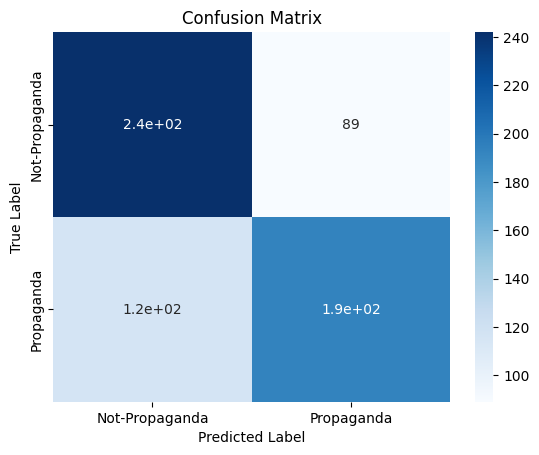

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(test_label2, predictions_xgbc2).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
models = ['MultinomialNB', 'Logistic Regression', 'SGD Classifier', 'XGBoost Classifier']
matrics_dict1 = {'Accuracy': accuracy2, 'F1-Score': f1_2}  # 'Models': model, 

model_df1 = pd.DataFrame(matrics_dict1.values(), columns = models).T
model_df1.columns = ['Accuracy', 'F1-score']
model_df1 = model_df1.sort_values(by = ['F1-score'], ascending = False)   # sort value according to highest f1-score 
model_df1

,Accuracy,F1-score
SGD Classifier,0.715625,0.715581
Logistic Regression,0.714063,0.714045
XGBoost Classifier,0.679688,0.677799
MultinomialNB,0.678125,0.668690


In [ ]:
tokens = [word_tokenize(sent) for sent in train_df2['tagged_in_context']]
print(tokens[0])
bigrams = [list(ngrams(token, 2)) for token in tokens]
print(bigrams[0])
freq= [FreqDist(bigram) for bigram in bigrams]     # calculate frequency of words in bigram
print(freq[:10])

['no', 'he', 'will', 'not', 'be', 'confirmed']
[('no', 'he'), ('he', 'will'), ('will', 'not'), ('not', 'be'), ('be', 'confirmed')]
[FreqDist({('no', 'he'): 1, ('he', 'will'): 1, ('will', 'not'): 1, ('not', 'be'): 1, ('be', 'confirmed'): 1}), FreqDist({('this', 'declassification'): 1, ('declassification', 'effort'): 1, ('effort', 'wont'): 1, ('wont', 'make'): 1, ('make', 'things'): 1, ('things', 'any'): 1, ('any', 'worse'): 1, ('worse', 'than'): 1, ('than', 'they'): 1, ('they', 'are'): 1, ...}), FreqDist({('the', 'obama'): 1, ('obama', 'administration'): 1, ('administration', 'misled'): 1, ('misled', 'the'): 1, ('the', 'american'): 1, ('american', 'people'): 1, ('people', 'and'): 1, ('and', 'congress'): 1, ('congress', 'because'): 1, ('because', 'they'): 1, ...}), FreqDist({('it', 'looks'): 1, ('looks', 'like'): 1, ('like', 'were'): 1, ('were', 'capturing'): 1, ('capturing', 'the'): 1, ('the', 'demise'): 1, ('demise', 'of'): 1, ('of', 'this'): 1, ('this', 'dark'): 1, ('dark', 'vortex'):

## Naive Bayes Classifier Implemented from the scratch for unigrams

In [ ]:
prop_df = train_df1.loc[train_df1['labels'] == 1] 
prop_df = prop_df.drop('label', axis = 1)
prop_df

,tagged_in_context,labels,span_text
2,obama administration misled american people co...,1,American people
5,hitler annihilated 400 000 germans handicapped...,1,annihilated
8,noted point literally every piece socalled evi...,1,so-called evidence
10,account suspended violating twitters rules rel...,1,hateful conduct
12,couple seemingly unrelated events past week po...,1,point to Iran’s positioning itself for more a...
...,...,...,...
2549,might think would cured facile nazi analogies,1,Nazi
2551,would like take opportunity make clear absolut...,1,absolutely no place for anti-Semitism
2552,trump jeff sessions put end russia probe prose...,1,Prosecutors Doing Mueller’s ‘Dirty Work Are A...
2553,neither democrat leadership democrat base care...,1,Neither the Democrat leadership nor the Democ...


In [ ]:
# prop_sents_train = [prop_df['tagged_in_context'].values]
# prop_sents_train

[array(['the obama administration misled the american people and congress because they were desperate to get a deal with iran said sen',
        'hitler annihilated 400 000 germans who were handicapped or suffered from chronic diseases',
        'as noted above at this point literally every piece of socalled evidence put forth by authorities and then regurgitated by the mainstream media cannot be trusted and should be considered as disinformation until proven otherwise',
        ...,
        'trump to jeff sessions put an end to russia probe prosecutors doing muellers dirty work are a disgrace to america',
        'neither the democrat leadership nor the democrat base cares that she married her brother she is a muslim and a leftist so she can further their identity politics thats all that matters to them',
        'in it jews are described as arrogant jealous selfish spiteful greedy cursed apes and swine and under divine displeasure'],
       dtype=object)]

In [ ]:
prop_data_train =  [(FreqDist(word_tokenize(sent)), "propaganda") for sent in prop_df['tagged_in_context']]
prop_data_train[:2]

[(FreqDist({'obama': 1, 'administration': 1, 'misled': 1, 'american': 1, 'people': 1, 'congress': 1, 'desperate': 1, 'get': 1, 'deal': 1, 'iran': 1, ...}),
  'propaganda'),
 (FreqDist({'hitler': 1, 'annihilated': 1, '400': 1, '000': 1, 'germans': 1, 'handicapped': 1, 'suffered': 1, 'chronic': 1, 'diseases': 1}),
  'propaganda')]

In [ ]:
not_prop_df = train_df1.loc[train_df1['labels'] == 0]
not_prop_df = not_prop_df.drop('label', axis = 1)
# not_prop_sents_train = [not_prop_df['tagged_in_context'].values]
not_prop_data_train =  [(FreqDist(word_tokenize(sent)), "not_propaganda") for sent in not_prop_df['tagged_in_context']]
not_prop_data_train[:2]

[(FreqDist({'confirmed': 1}), 'not_propaganda'),
 (FreqDist({'declassification': 1, 'effort': 1, 'wont': 1, 'make': 1, 'things': 1, 'worse': 1, 'president': 1, 'trump': 1}),
  'not_propaganda')]

In [ ]:
train_data = prop_data_train + not_prop_data_train
train_data[:5]
# training_data = [(FreqDist(sent.split()), train_label2) for sent,label in (train_sentences2,train_label2)]
# training_data[:5]

[(FreqDist({'obama': 1, 'administration': 1, 'misled': 1, 'american': 1, 'people': 1, 'congress': 1, 'desperate': 1, 'get': 1, 'deal': 1, 'iran': 1, ...}),
  'propaganda'),
 (FreqDist({'hitler': 1, 'annihilated': 1, '400': 1, '000': 1, 'germans': 1, 'handicapped': 1, 'suffered': 1, 'chronic': 1, 'diseases': 1}),
  'propaganda'),
 (FreqDist({'noted': 1, 'point': 1, 'literally': 1, 'every': 1, 'piece': 1, 'socalled': 1, 'evidence': 1, 'put': 1, 'forth': 1, 'authorities': 1, ...}),
  'propaganda'),
 (FreqDist({'hateful': 2, 'conduct': 2, 'account': 1, 'suspended': 1, 'violating': 1, 'twitters': 1, 'rules': 1, 'relating': 1, 'apparently': 1, 'reference': 1, ...}),
  'propaganda'),
 (FreqDist({'couple': 1, 'seemingly': 1, 'unrelated': 1, 'events': 1, 'past': 1, 'week': 1, 'point': 1, 'irans': 1, 'positioning': 1, 'aggressive': 1, ...}),
  'propaganda')]

In [ ]:
test_prop_df = test_df1.loc[test_df1['labels'] == 1]
test_prop_df = test_prop_df.drop('label', axis = 1)
prop_data_test =  [(FreqDist(word_tokenize(sent)), "propaganda") for sent in test_prop_df['tagged_in_context']]

test_not_prop_df = test_df1.loc[test_df1['labels'] == 0]
test_not_prop_df = test_not_prop_df.drop('label', axis = 1)
not_prop_data_test =  [(FreqDist(word_tokenize(sent)), "not_propaganda") for sent in test_not_prop_df['tagged_in_context']]
not_prop_data_test[:2]

[(FreqDist({'average': 1, '300': 1, '600': 1, 'infections': 1, 'recorded': 1, 'every': 1, 'year': 1, 'among': 1, 'population': 1, 'approaching': 1, ...}),
  'not_propaganda'),
 (FreqDist({'may': 1, 'opt': 1, 'anytime': 1}), 'not_propaganda')]

In [ ]:
test_data = prop_data_test + not_prop_data_test
test_data[:5]

[(FreqDist({'country': 2, 'mostly': 1, 'would': 1, 'last': 1, 'long': 1, 'without': 1, 'outside': 1, 'high': 1, 'iq': 1, 'elite': 1, ...}),
  'propaganda'),
 (FreqDist({'warren': 2, 'lyndon': 1, 'johnson': 1, 'gets': 1, 'earl': 1, 'sen': 1, 'richard': 1, 'russel': 1, 'join': 1, 'commission': 1, ...}),
  'propaganda'),
 (FreqDist({'must': 1, 'exacted': 1, 'directly': 1, 'order': 1, 'vilify': 1, 'humiliate': 1, 'islam': 1, 'people': 1, 'may': 1, 'exalted': 1, ...}),
  'propaganda'),
 (FreqDist({'wonder': 1, 'priests': 1, 'laity': 1, 'alike': 1, 'changing': 1, 'attitude': 1, 'gay': 1, 'lifestyle': 1, 'violations': 1, 'sixth': 1, ...}),
  'propaganda'),
 (FreqDist({'communities': 2, 'health': 1, 'workers': 1, 'asked': 1, 'work': 1, 'stop': 1, 'deadly': 1, 'marburg': 1, 'outbreak': 1, 'devastating': 1, ...}),
  'propaganda')]

In [ ]:
from nltk.classify.api import ClassifierI

class NBClassifier(ClassifierI):
    
    def __init__(self):
        
        pass
    
    def set_known_vocabulary(self,training_data):
        known= []
        for doc,label in training_data:
            known += list(doc.keys())
        self.known = set(known)
    
    def set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors
        
    def set_conditional_probs(self,training_data):       
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1
        
            conds[label]=classcond
    
        for label, classcond in conds.items():
            for word in self.known:
        
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
            
        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}
        
        self.conds=conds
    
    def train(self,training_data):
        self.set_known_vocabulary(training_data)
        self.set_priors(training_data)
        self.set_conditional_probs(training_data)
    
    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

In [ ]:
nb_classifier=NBClassifier()
nb_classifier.train(train_data)
nb_classifier.classify_many(sent for (sent,label) in test_data)

['propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'not_propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'not_propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'propaganda',
 'p

In [ ]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "propaganda" or "not_propaganda"
    test_data: a list of pairs where each pair is a FreqDist rep of a sentence and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    acc = 0
    sents,label=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(sents)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,label):
        if prediction==goldlabel:
            acc+=1
    
    return acc / (len(test_data))

In [ ]:
accuracy=classifier_evaluate(nb_classifier,test_data)
print("The accuracy of NB classifier is {}".format(accuracy))

The accuracy of NB classifier is 0.703125


In [ ]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=labels):
    
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):
        #put your code to compute precision here
        p = self.TP / (self.TP + self.FP)

        return p

    def recall(self):
        r=0
        #put your code to compute recall here
        r = self.TP / (self.TP + self.FN)

        return r

    def f1(self):
        f1=0
        #put your code to compute f1 here
        p=self.precision()
        r=self.recall()
        f1=2*(p*r)/(p+r)

        return f1 

In [ ]:
sents,label =  zip(*test_data)
cm=ConfusionMatrix(nb_classifier.classify_many(sents),label,classes=("propaganda","not_propaganda"))
print("Precision: {}".format(cm.precision()))
print("Recall: {}".format(cm.recall()))
print("F1-score: {}".format(cm.f1()))

Precision: 0.6553524804177546
Recall: 0.8122977346278317
F1-score: 0.7254335260115607


In [ ]:
from nltk.classify import NaiveBayesClassifier

nltk_nb=NaiveBayesClassifier.train(train_data)
accuracy=classifier_evaluate(nltk_nb,test_data)
print("The accuracy of NB classifier is {}".format(accuracy))
print("-----------------------------")
cm=ConfusionMatrix(nltk_nb.classify_many(sents),label,classes=("propaganda","not_propaganda"))
print("Precision: {}".format(cm.precision()))
print("Recall: {}".format(cm.recall()))
print("F1-score: {}".format(cm.f1()))

The accuracy of NB classifier is 0.6421875
-----------------------------
Precision: 0.5826446280991735
Recall: 0.912621359223301
F1-score: 0.7112232030264817


## Gensim Word2Vec

Word2Vec is widely used in many applications like document similarity and retrieval, machine translations, etc.

In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm
from collections import defaultdict

In [ ]:
tokenized_sents=[]
for sent in tqdm(train_sentences):
    tokenized_sents.append(sent.split())

100%|██████████| 2560/2560 [00:00<00:00, 258814.04it/s]


In [ ]:
test_tokenized_sents=[]
for sent in tqdm(test_sentences):
    test_tokenized_sents.append(sent.split())

100%|██████████| 640/640 [00:00<00:00, 273550.86it/s]


####Training a Word2Vec Model

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
print(gensim.__version__)

4.3.1


In [ ]:
model_wv = Word2Vec(sentences=tokenized_sents, min_count=1, vector_size=100, window=5, workers = 2, seed = random_seed)

In [ ]:
# Total number of words in the Vocabulary on which the Word2Vec model is trained.

vocab_wv = list(model_wv.wv.index_to_key)
print(len(vocab_wv))

8984


In [ ]:
vocab_wv[0:10]

['said',
 'us',
 'one',
 'people',
 'trump',
 'would',
 'church',
 'also',
 'even',
 'president']

In [ ]:
model_wv.wv.get_vector('people')

array([-0.02217443,  0.02730965,  0.00650991, -0.00069947,  0.00610762,
       -0.02381274,  0.00089077,  0.03968944, -0.00540566, -0.01567476,
        0.00469315, -0.01675571, -0.00103775, -0.00077594,  0.01434085,
       -0.01706158,  0.01129336, -0.02604226, -0.0086039 , -0.02027073,
        0.01378803,  0.00383106,  0.02449007,  0.00525317, -0.01080041,
        0.00418623, -0.00397395, -0.00233467, -0.01527041, -0.00115577,
        0.01955747, -0.00171637, -0.01034229, -0.0099749 ,  0.00353762,
        0.02486673,  0.01453645, -0.01975972, -0.01620311, -0.01642651,
        0.00826848, -0.01150071, -0.00011367, -0.00196629,  0.01917628,
       -0.00229376, -0.01007297, -0.00023736,  0.00465956,  0.00903604,
        0.00853296, -0.01447375, -0.01488206, -0.01850551, -0.02023065,
        0.00503826,  0.01400605,  0.01156972, -0.00472966, -0.0017497 ,
        0.00219557,  0.01357602, -0.00084232, -0.00087556, -0.00917597,
        0.00640975,  0.0006832 ,  0.01571124, -0.01528633,  0.00

In [ ]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats_w2vec(token_list, model):
    dimension = 100
    zero_vector = np.zeros(dimension)
    feats = []
    for tokens in token_list:
        vector =  np.zeros(dimension)
        count = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in model.wv:
                vector += model.wv[token]
                count +=1
        if(count!=0):
            feats.append(vector/count) 
        else:
            feats.append(zero_vector)
    return feats

In [ ]:
train_transformed=embedding_feats_w2vec(tokenized_sents, model_wv)
test_transformed=embedding_feats_w2vec(test_tokenized_sents, model_wv)

In [ ]:
train_transformed[0]

array([ 2.29519592e-03, -6.77380829e-03,  2.01420081e-04, -5.04683080e-03,
        7.51952292e-03, -4.71614661e-03, -2.70422754e-03,  5.83194697e-03,
        6.54910522e-03, -3.85229069e-03, -9.43918400e-03,  4.45463850e-03,
        3.79378559e-03,  1.42843594e-03,  8.27367991e-03, -8.41599948e-03,
        2.53666124e-03,  8.20469009e-03,  4.57399980e-03, -5.97720251e-03,
        4.71790865e-03,  9.43675514e-03,  6.07026072e-03,  9.56181374e-03,
       -1.51559825e-03,  6.56590238e-03, -6.35569846e-03, -7.61009826e-03,
        6.14857672e-03, -2.58479733e-03, -8.00656341e-05,  3.03561884e-03,
        5.30091494e-03,  9.22526693e-03,  8.18381377e-03, -4.59021396e-03,
        8.08304766e-04,  6.49884969e-03, -8.76539842e-03,  1.61187380e-03,
        2.41645361e-03,  2.36475524e-03,  5.30674054e-04, -1.37726668e-03,
       -1.31518557e-03, -3.70794133e-03, -2.94971357e-03,  9.62851347e-03,
       -3.70948894e-03, -4.98800114e-03, -6.57314707e-03, -5.01636708e-03,
        4.92914074e-03,  

In [ ]:
test_transformed[0]

array([-3.00254832e-03,  5.96882165e-03, -6.89365985e-04,  5.06452712e-04,
        5.45180815e-05, -4.89042688e-03,  5.80721935e-04,  8.10037830e-03,
       -1.54038161e-03, -6.28151171e-04, -2.06118351e-04, -8.00536971e-04,
       -8.17861660e-04, -1.01502144e-03,  4.10482673e-04, -3.87289695e-03,
        2.74451697e-03, -3.85852080e-03,  1.65302663e-03, -4.45306194e-03,
        4.44760386e-03,  3.15729629e-03,  4.34576066e-03, -2.05667661e-03,
       -1.79503622e-03,  4.39803851e-04, -1.13684171e-04, -2.90058246e-03,
       -4.06239094e-03, -7.42613459e-04,  2.77599471e-03,  2.09531596e-03,
       -3.15913884e-03, -1.67015913e-03,  7.20069544e-04,  3.21861518e-03,
        6.89250087e-04, -3.63071289e-03, -1.26517675e-03, -3.99014209e-03,
        6.05300499e-04, -3.61591098e-03, -2.22286142e-03,  2.13464555e-04,
        2.22282022e-03, -2.61687207e-03, -1.93029417e-03, -2.08021848e-03,
       -1.72010368e-03,  1.38311719e-03,  3.93845973e-04, -2.94291160e-03,
       -1.68658383e-03, -

In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "XGBoost",
]

model_list = [
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state = random_seed),
    KNeighborsClassifier(n_neighbors = 7, n_jobs = -1),
    DecisionTreeClassifier(random_state=random_seed),
    SVC(kernel = 'linear', random_state = random_seed),
    RandomForestClassifier(n_estimators = 100, random_state = random_seed),
    SGDClassifier(loss = 'hinge', random_state = random_seed),
    XGBClassifier(random_state = random_seed),
]

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_test, y_test, names = names, models = model_list):
    score_df, score_train, score_test, f1_ = pd.DataFrame(), [], [], []
    for model in model_list:
        model.fit(X_train, y_train)
        y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_test.append(accuracy_score(y_test, y_test_pred))
        f1_.append(f1_score(y_test, y_test_pred, average='macro'))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Test accuracy"], score_df["F1-Score"] = names, score_train, score_test, f1_
    score_df.sort_values(by = 'Test accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Summary of baseline models
score(train_transformed, train_label, test_transformed, test_label, names = names, models = model_list)

,Classifier,Training accuracy,Test accuracy,F1-Score
4,Random Forest,0.998828,0.640625,0.635485
6,XGBoost,0.998828,0.635938,0.634845
2,Decision Tree,0.998828,0.585938,0.585936
1,KNN Classifier,0.633984,0.560937,0.512891
5,SGD Classifier,0.565234,0.554688,0.518702
0,Logistic Regression,0.511719,0.487500,0.348042
3,Linear SVM,0.504297,0.482812,0.325606


### Model Evaluation

Using Random Forest Classifier to predict whether a given sentence is propaganda or not.

In [ ]:
np.any(np.isnan(train_transformed))

False

In [ ]:
# random forest classifier
clf_rfc = RandomForestClassifier(n_estimators = 100, random_state=random_seed)
clf_rfc.fit(train_transformed,train_label)
predictions_rfc = clf_rfc.predict(test_transformed)

In [ ]:
labels = ["Not-Propaganda", "Propaganda"]
print('accuracy: %s' % accuracy_score(predictions_rfc, test_label))
print(classification_report(test_label, predictions_rfc, target_names=labels))
print('f1 score: %s' % f1_score(test_label, predictions_rfc, average='macro'))

accuracy: 0.640625
                precision    recall  f1-score   support

Not-Propaganda       0.63      0.73      0.68       331
    Propaganda       0.65      0.54      0.59       309

      accuracy                           0.64       640
     macro avg       0.64      0.64      0.64       640
  weighted avg       0.64      0.64      0.64       640

f1 score: 0.635484765640477



Plotting the ROC curve for the prediction on Testing Data

In [ ]:
predict_prob_rfc = clf_rfc.predict_proba(test_transformed)[:,1]
# predict_prob_rfc

In [ ]:
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
# train_fpr,train_tpr,thresholds=roc_curve(train_df1["labels"],clf_rfc.predict_proba(train_transformed)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(test_label, predict_prob_rfc)

Random Forest Classifier - Auc: 0.68


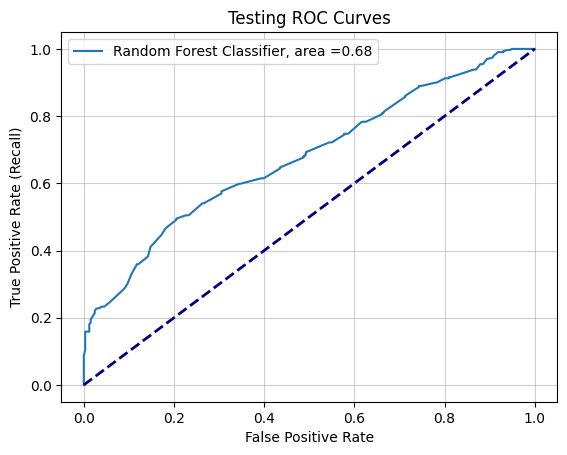

In [ ]:
import matplotlib.pyplot as plt
auc_rfc = roc_auc_score(test_label, predict_prob_rfc, 
                            multi_class="ovr")
print("Random Forest Classifier - Auc:", round(auc_rfc,2))

plt.plot(test_fpr,test_tpr,label="Random Forest Classifier, area ="+str(round(auc(test_fpr, test_tpr),2)))

plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Positive Rate') 
plt.ylabel("True Positive Rate (Recall)")
plt.title("Testing ROC Curves")
plt.grid(True, alpha = 0.6)
plt.show()

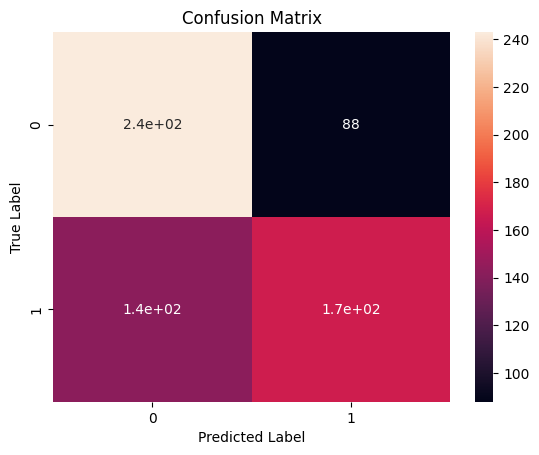

In [ ]:
sns.heatmap(confusion_matrix(test_label,predictions_rfc),annot=True)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

## Google news negative word2vec

A pre-trained Word2vec model for doing feature extraction and performing text classification.

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from gensim.models import KeyedVectors
from scipy.sparse import csr_matrix
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# download GoogleNews-vectors-negative300.bin.gz
# https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
# Or 
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [ ]:
# Loading the pre-trained Word2Vec model
# word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [ ]:
def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2, random_state = random_seed)       # Dimensionality reduction using truncated SVD
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['blue', 'red']
        
    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = mcolors.ListedColormap(colors))
    blue_patch = mpatches.Patch(color = 'blue', label = 'not propaganda')
    red_patch = mpatches.Patch(color = 'red', label = 'propaganda')
    plt.legend(handles = [blue_patch, red_patch], prop = {"size": 12})

# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists, model):
    dimension = 300
    zero_vector = np.zeros(dimension)
    feats = []
    for tokens in list_of_lists:
        vector =  np.zeros(dimension)
        count = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in model:
                vector += model[token]
                count +=1
        if(count!=0):
            feats.append(vector/count) 
        else:
            feats.append(zero_vector)
    return feats

In [ ]:
train_vectors = embedding_feats(tokenized_sents, word2vec)
test_vectors = embedding_feats(test_tokenized_sents, word2vec)

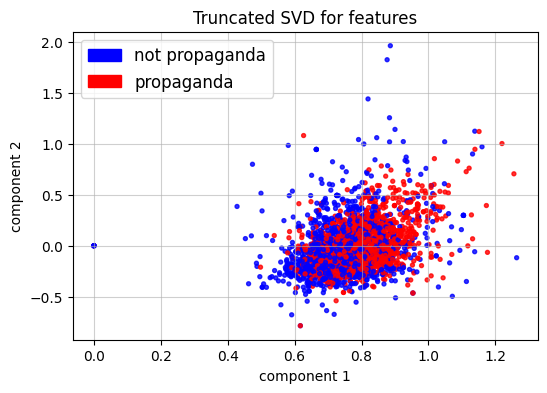

In [ ]:
fig = plt.figure(figsize = (6, 4))          
plot_embedding(train_vectors, train_label)
plt.grid(alpha = 0.6)
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("Truncated SVD for features")

plt.show()

In [ ]:
# Summary of baseline models
score(train_vectors, train_label, test_vectors, test_label, names = names, models = models)

,Classifier,Training accuracy,Test accuracy,F1-Score
6,XGBoost,0.998828,0.721875,0.721483
4,Random Forest,0.998828,0.712500,0.710589
0,Logistic Regression,0.755859,0.700000,0.700000
3,Linear SVM,0.766797,0.700000,0.700000
5,SGD Classifier,0.775000,0.681250,0.678965
2,Decision Tree,0.998828,0.632812,0.632740
1,KNN Classifier,0.694531,0.603125,0.564766


### Model Evaluation

Using XGB Classifier to predict whether a given sentence is propaganda or not.

In [ ]:
np.any(np.isnan(train_vectors))

False

In [ ]:
# random forest classifier
clf_xgb = XGBClassifier( random_state=random_seed)
clf_xgb.fit(train_vectors,train_label)
predictions_xgb = clf_xgb.predict(test_vectors)

In [ ]:
labels = ["Not-Propaganda", "Propaganda"]
print('accuracy: %s' % accuracy_score(predictions_xgb, test_label))
print(classification_report(test_label, predictions_xgb, target_names=labels))
print('f1 score: %s' % f1_score(test_label, predictions_xgb, average='macro'))

accuracy: 0.721875
                precision    recall  f1-score   support

Not-Propaganda       0.73      0.73      0.73       331
    Propaganda       0.71      0.71      0.71       309

      accuracy                           0.72       640
     macro avg       0.72      0.72      0.72       640
  weighted avg       0.72      0.72      0.72       640

f1 score: 0.7214833359411672



### Plotting the ROC curve for the prediction on Testing Data and comparing with Random Forest CLassifier which work best with Gensim Word2Vec.

In [ ]:
predict_prob_xgb = clf_xgb.predict_proba(test_vectors)[:,1]
predict_prob_xgb[:5]

array([2.2219689e-01, 5.0876176e-01, 7.1677113e-01, 3.4936614e-04,
       9.9952185e-01], dtype=float32)

In [ ]:
# fpr, tpr calculation 
fpr_xgb,tpr_xgb,thresholds=roc_curve(test_label,predict_prob_xgb)

XGB - Auc: 0.8


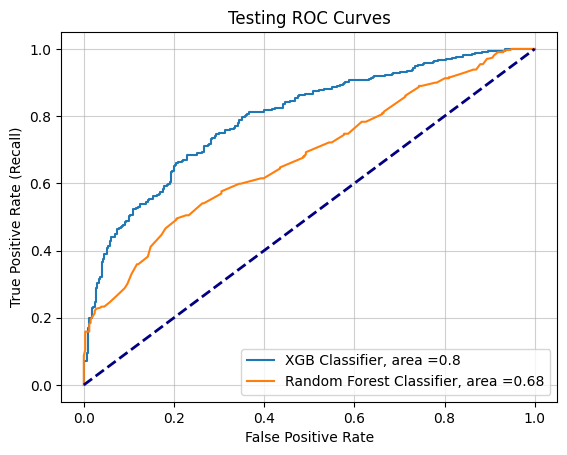

In [ ]:

auc_xgb = roc_auc_score(test_label, predict_prob_xgb, 
                            multi_class="ovr")
print("XGB - Auc:", round(auc_xgb,2))
plt.plot(fpr_xgb,tpr_xgb,label="XGB Classifier, area ="+str(round(auc(fpr_xgb, tpr_xgb),2)))
plt.plot(test_fpr,test_tpr,label="Random Forest Classifier, area ="+str(round(auc(test_fpr, test_tpr),2)))

plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Positive Rate') 
plt.ylabel("True Positive Rate (Recall)")
plt.title("Testing ROC Curves")
plt.grid(True, alpha = 0.6)
plt.show()

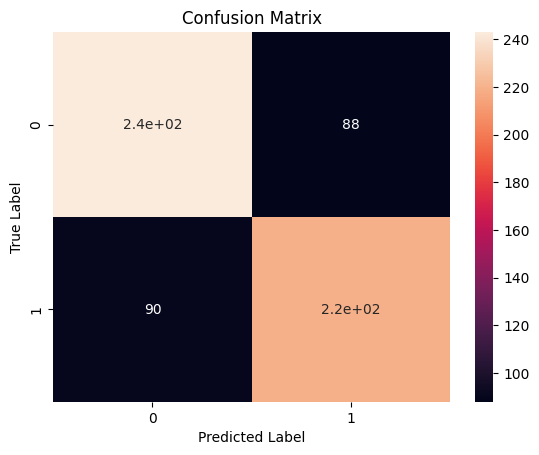

In [ ]:
sns.heatmap(confusion_matrix(test_label,predictions_xgb),annot=True)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

## Neural Network

### Propaganda detection using CNN

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from numpy import array

In [ ]:
def get_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_length(lines):
    return max([len(sentence.split()) for sentence in lines])

def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

def define_model(length, vocab_size, channels, kernel_size):
    inputs = {}
    embedding = {}
    conv = {}
    drop = {}
    pool = {}
    flat = {}
    for channel in range(1, channels + 1):
        inputs[channel] = Input(shape = (length,), dtype ='float64')
        embedding[channel] = Embedding(vocab_size, 100)(inputs[channel])
        conv[channel] = Conv1D(filters = 32, kernel_size = kernel_size[channel], activation = 'relu')(embedding[channel])
        drop[channel] = Dropout(0.5)(conv[channel])
        pool[channel] = MaxPooling1D(pool_size = 2)(drop[channel])
        flat[channel] = Flatten()(pool[channel])
    merged = concatenate(list(flat.values()))
    dense = Dense(10, activation = 'relu')(merged)
    outputs = Dense(2, activation = 'softmax')(dense)
    
    model = Model(list(inputs.values()), outputs=outputs)
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    print(model.summary())
    # plot_model(model, show_shapes = True, to_file = '/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/multichannel.png')
    return model

In [ ]:
X_train = train_df1['tagged_in_context'].values
Y_train = train_df1['labels'].values

X_test = test_df1['tagged_in_context'].values
Y_test = test_df1['labels'].values

# Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
# Y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2560,) (2560,)
(640,) (640,)


In [ ]:
max([len(sentence.split()) for sentence in X_train])

76

In [ ]:
tokenizer = get_tokenizer(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8977


In [ ]:
tokenizer = get_tokenizer(X_train)
length = max_length(X_train)
vocab_size = len(tokenizer.word_index) + 1
X_train = encode_text(tokenizer, X_train, length)
model = define_model(length, vocab_size, 3, {1 : 8, 2 : 6, 3 : 4})
history = model.fit([X_train, X_train, X_train], array(Y_train), epochs = 10, batch_size = 32, verbose = 1)  #  validation_data=([X_test,X_test,X_test], array(Y_test))

# applying same for testing data
tokenizer = get_tokenizer(X_test)
X_test = encode_text(tokenizer, X_test, length)
loss, acc = model.evaluate([X_test,X_test,X_test],array(Y_test), verbose=1)

# model.save('/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/model_SI.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 76, 100)      897700      ['input_1[0][0]']                
                                                                                              

In [ ]:
print("Test Accuracy: ",acc)
print("Test Loss: ",loss)

Test Accuracy:  0.5703125
Test Loss:  1.6869146823883057


In [ ]:
y_pred = model.predict([X_test, X_test, X_test])
y_pred = np.round(y_pred)

20/20 [==============================] - 0s 2ms/step


In [ ]:
#convert y_predict from one-hot encoding to label encoding
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [ ]:
labels = ["Not-Propaganda", "Propaganda"]
print('accuracy: %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred, target_names=labels))
print('f1 score: %s' % f1_score(Y_test, y_pred, average='macro'))

accuracy: 0.5703125
                precision    recall  f1-score   support

Not-Propaganda       0.65      0.37      0.47       331
    Propaganda       0.54      0.79      0.64       309

      accuracy                           0.57       640
     macro avg       0.59      0.58      0.55       640
  weighted avg       0.60      0.57      0.55       640

f1 score: 0.5514880579376593


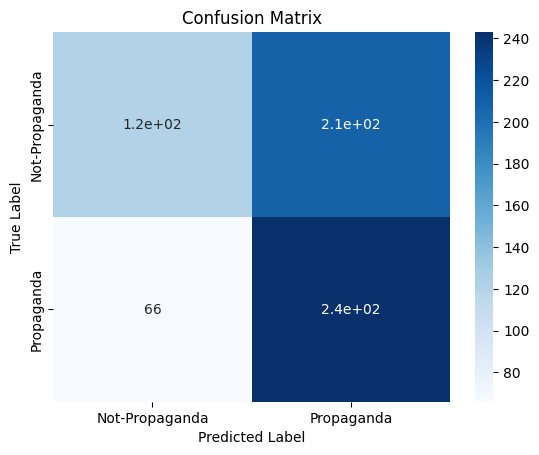

In [ ]:
# Plotting a confusion matrix
cm_ = confusion_matrix(Y_test, y_pred)#.astype(int)
sns.heatmap(cm_, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### BiLSTM

Global Vector or GloVe is an unsupervised learning algorithm for obtaining vector representations for words. I used glove.6B.100d to get word vector representation.

In [ ]:
# download glove.6B.zip
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-15 17:17:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-15 17:17:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-15 17:17:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
#unzip the file, we get multiple embedding files. We can use either one of them
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embedding_dict = {}
# glove_file = open("glove.6B.100d.txt", encoding = "utf8")
glove_file = open("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/glove.6B.100d.txt", encoding = "utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.asarray(records[1:], dtype = "float64")
  embedding_dict[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
# let’s have a quick look how many of the embedding vectors are nonzero:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.42853960120307455

In [ ]:
embedding_vector_length = 100

In [ ]:
# A simple bidirectional LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(vocab_size, #Vocablury size
                    embedding_vector_length, #Embedding size
                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                    trainable=True, 
                    input_length=length,      #Number of words in each review
                    ) 
         )
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))  
model.add(Dense(units=32, activation = 'relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 76, 100)           897700    
                                                                 
 bidirectional (Bidirectiona  (None, 600)              962400    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                19232     
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,879,398
Trainable params: 1,879,398
Non-trainable params: 0
_________________________________________________________________


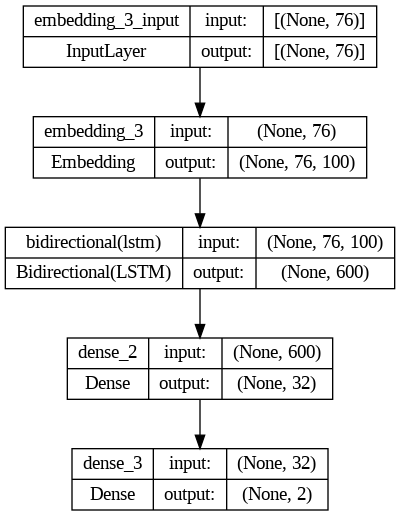

In [ ]:
# plot_model(model, show_shapes = True, to_file = '/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/bilstm_1.png')

In [ ]:
history=model.fit(X_train,Y_train,
          epochs=3,
          batch_size=32,          
          validation_data=(X_test, Y_test))

Epoch 1/3
80/80 [==============================] - 48s 547ms/step - loss: 0.6732 - accuracy: 0.5805 - val_loss: 0.6639 - val_accuracy: 0.6094
Epoch 2/3
80/80 [==============================] - 37s 465ms/step - loss: 0.6263 - accuracy: 0.6598 - val_loss: 0.6822 - val_accuracy: 0.6125
Epoch 3/3
80/80 [==============================] - 35s 433ms/step - loss: 0.5221 - accuracy: 0.7555 - val_loss: 0.7004 - val_accuracy: 0.6156


In [ ]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

20/20 [==============================] - 3s 141ms/step - loss: 0.7004 - accuracy: 0.6156
Test loss:  0.7004375457763672
Test accuracy:  0.6156250238418579


In [ ]:
y_predict_bilstm = model.predict(X_test)

20/20 [==============================] - 1s 50ms/step


In [ ]:
y_predict_bilstm = np.argmax(y_predict_bilstm, axis = 1)
y_predict_bilstm

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,

In [ ]:
print('accuracy: %s' % accuracy_score(y_predict_bilstm, Y_test))
print(classification_report(Y_test, y_predict_bilstm, target_names=labels))
print('f1 score: %s' % f1_score(Y_test, y_predict_bilstm, average='macro'))

accuracy: 0.615625
                precision    recall  f1-score   support

Not-Propaganda       0.63      0.64      0.63       331
    Propaganda       0.60      0.59      0.60       309

      accuracy                           0.62       640
     macro avg       0.62      0.61      0.61       640
  weighted avg       0.62      0.62      0.62       640

f1 score: 0.6148878713161912


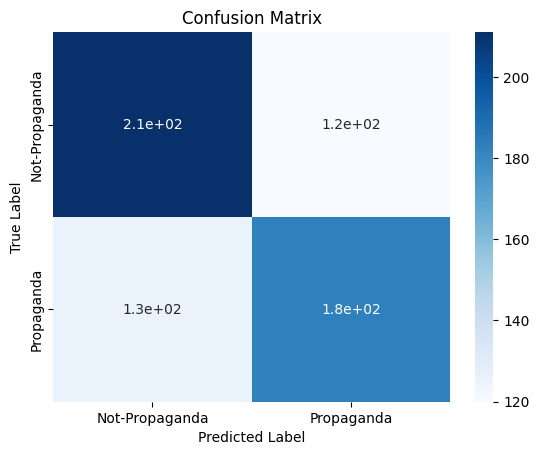

In [ ]:
# Plotting a confusion matrix
cm_lstm = confusion_matrix(Y_test, y_predict_bilstm).astype(int)
sns.heatmap(cm_lstm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## BERT

### Transfer Learning 

I used pre trained `TFBertForSequenceClassification` model for fine tuning.

**Prepare the data**

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.7 MB/s eta 0:00:00


In [ ]:
from transformers import *
# for reproductivity of results
from transformers import set_seed
set_seed(random_seed)

In [ ]:
# using training and test data only removing special characters and making lowercase.
train_text = train_df2['tagged_in_context'].values
train_label = train_df2['labels'].values

test_text = test_df2['tagged_in_context'].values
test_label = test_df2['labels'].values

In [ ]:
### tokenize data using bert tokenizer
#Get BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_train_texts = [tokenizer.tokenize(sent) for sent in train_text]

#We will use only first 120 tokens to do classification
max_length = 120
tokenized_train_texts = [sent[:max_length] for sent in tokenized_train_texts]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
for i in range(len(tokenized_train_texts)):
    sent = tokenized_train_texts[i]
    sent = ['[CLS]'] + sent + ['[SEP]']
    tokenized_train_texts[i] = sent
    
#Convert tokens into IDs
input_train_ids = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_train_texts]

In [ ]:
tokenized_train_texts[0]

['[CLS]', 'no', 'he', 'will', 'not', 'be', 'confirmed', '[SEP]']

In [ ]:
input_train_ids[0]

[101, 2053, 2002, 2097, 2025, 2022, 4484, 102]

In [ ]:
#Pad our tokens which might be less than max_length size
input_train_ids = pad_sequences(input_train_ids, maxlen=max_length+2, truncating='post', padding='post')

In [ ]:
tokenized_test_texts = [tokenizer.tokenize(sent) for sent in test_text]
tokenized_test_texts = [sent[:max_length] for sent in tokenized_test_texts]

for i in range(len(tokenized_test_texts)):
    sent = tokenized_test_texts[i]
    sent = ['[CLS]'] + sent + ['[SEP]']
    tokenized_test_texts[i] = sent
    
#Convert tokens into IDs
input_test_ids = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_test_texts]

#Pad our tokens which might be less than max_length size
input_test_ids = pad_sequences(input_test_ids, maxlen=max_length+2, truncating='post', padding='post')

Create Attention masks : Attention masks are useful to ignore padding tokens. Mask value will be set to 0 for padding tokens and 1 for actual tokens. We will create mask both for training and test data

In [ ]:
# Create attention masks for training
train_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_train_ids:
  seq_mask = [float(i>0) for i in seq]
  train_attn_masks.append(seq_mask)

In [ ]:
# Create attention masks for Test
test_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_test_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attn_masks.append(seq_mask)

In [ ]:
model_tfb = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy('accuracy')
model_tfb.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_tfb.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_40 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_x_data = {'input_ids': np.array(input_train_ids), 'attention_mask': np.array(train_attn_masks)}
test_x_data = {'input_ids': np.array(input_test_ids), 'attention_mask': np.array(test_attn_masks)}

In [ ]:
model_tfb.fit(train_x_data, train_label, validation_data=(test_x_data, test_label), batch_size=16, epochs=2)

Epoch 1/2
160/160 [==============================] - 111s 482ms/step - loss: 0.5570 - accuracy: 0.7152 - val_loss: 0.4932 - val_accuracy: 0.7625
Epoch 2/2
160/160 [==============================] - 77s 481ms/step - loss: 0.3359 - accuracy: 0.8605 - val_loss: 0.5819 - val_accuracy: 0.7406


In [ ]:
model_tfb.fit(train_x_data, train_label, validation_data=(test_x_data, test_label), batch_size=32, epochs=5)

Epoch 1/5
80/80 [==============================] - 92s 959ms/step - loss: 0.1171 - accuracy: 0.9602 - val_loss: 0.7335 - val_accuracy: 0.7812
Epoch 2/5
80/80 [==============================] - 74s 923ms/step - loss: 0.0338 - accuracy: 0.9934 - val_loss: 0.9380 - val_accuracy: 0.7875
Epoch 3/5
80/80 [==============================] - 73s 915ms/step - loss: 0.0158 - accuracy: 0.9977 - val_loss: 1.1975 - val_accuracy: 0.7516
Epoch 4/5
80/80 [==============================] - 73s 915ms/step - loss: 0.0156 - accuracy: 0.9973 - val_loss: 1.0818 - val_accuracy: 0.7594
Epoch 5/5
80/80 [==============================] - 73s 917ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 1.1234 - val_accuracy: 0.7594


In [ ]:
## this object return scored before softmax
test_pred = model_tfb.predict(test_x_data)[0]
test_pred

20/20 [==============================] - 8s 260ms/step


array([[ 2.3662324 , -3.3917747 ],
       [-2.5262809 ,  3.5348544 ],
       [ 0.3761235 , -0.23991917],
       ...,
       [ 2.9986687 , -3.4855323 ],
       [-1.6691637 ,  2.7986512 ],
       [ 0.24230382, -0.43592834]], dtype=float32)

In [ ]:
## this will return probability score
tf_prediction = tf.nn.softmax(test_pred, axis=1).numpy()


In [ ]:
## this will return predicted class labels
tf_prediction=np.argmax(tf_prediction,axis=1)
np.unique(tf_prediction)

array([0, 1])

In [ ]:
labels = ["Propaganda", "Not-Propaganda"]
print('accuracy: %s' % accuracy_score(tf_prediction, test_label))
print(classification_report(test_label, tf_prediction, target_names=labels))
print('f1 score: %s' % f1_score(test_label, tf_prediction, average='macro'))

accuracy: 0.759375
                precision    recall  f1-score   support

    Propaganda       0.76      0.78      0.77       331
Not-Propaganda       0.76      0.73      0.75       309

      accuracy                           0.76       640
     macro avg       0.76      0.76      0.76       640
  weighted avg       0.76      0.76      0.76       640

f1 score: 0.7587719298245614


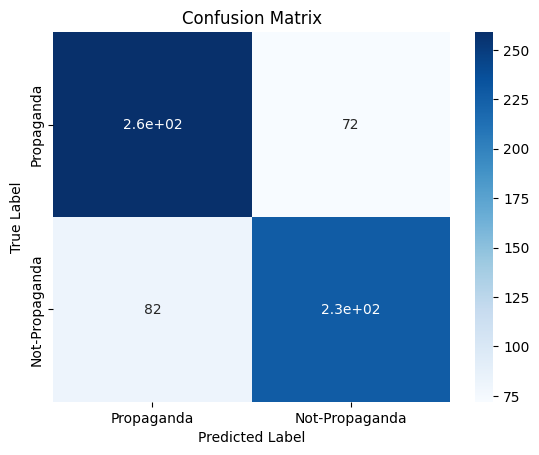

In [ ]:
# Plotting a confusion matrix
cm_tfb = confusion_matrix(test_label, tf_prediction).astype(int)
sns.heatmap(cm_tfb, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Training BERT

In [ ]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.2 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_df3 = train_df.copy()
train_df3['labels'] = train_df3['label']
train_df3.loc[train_df3['label'] != 'not_propaganda', 'labels'] = "propaganda"

In [ ]:
test_df3 = test_df.copy()
test_df3['labels'] = test_df3['label']
test_df3.loc[test_df3['label'] != 'not_propaganda', 'labels'] = "propaganda"

In [ ]:
labellist=sorted(list(set(train_df3['labels'].unique()).union(set(test_df3['labels'].unique())))) 

labels_dict={label:i for i,label in enumerate(labellist)}
labels_dict

{'not_propaganda': 0, 'propaganda': 1}

In [ ]:
train_df3 = train_df3.replace({'labels':labels_dict})
train_df3

,label,tagged_in_context,labels
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",0
1,not_propaganda,This declassification effort <BOS> won’t make ...,0
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",1
3,not_propaganda,“It looks like we’re capturing the demise of t...,0
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",0
...,...,...,...
2555,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,0
2556,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,0
2557,not_propaganda,What has been done: there has been work on for...,0
2558,not_propaganda,This is <BOS> the law of gradualness not the g...,0


In [ ]:
test_df3 = test_df3.replace({'labels':labels_dict})
test_df3

,label,tagged_in_context,labels
0,not_propaganda,"On average, between 300 and 600 infections are...",0
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0
4,repetition,It must be exacted from him directly in order ...,1
...,...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...",0
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",0
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,0
638,flag_waving,<BOS> He also sang an Islamic State fight song...,1


In [ ]:
# Only making sentences lower case and removing special chatacters
def preprocess_text2(text):
    #black_list = ["bos", "eos"]
    text = text.lower() # lowercase text
    text = re.sub('[^0-9A-Za-z]+', ' ', text)
    text = ' '.join(word for word in text.split()) 
    return text

In [ ]:
train_df3['tagged_in_context'] = train_df3['tagged_in_context'].apply(preprocess_text2)
test_df3['tagged_in_context'] = test_df3['tagged_in_context'].apply(preprocess_text2)

In [ ]:
train_text = train_df3['tagged_in_context'].values
tokenized_text = [sent.split() for sent in train_text]
print(tokenized_text[10])

['his', 'account', 'was', 'suspended', 'for', 'violating', 'twitter', 's', 'rules', 'relating', 'to', 'bos', 'hateful', 'conduct', 'eos', 'it', 'is', 'hateful', 'conduct', 'apparently', 'to', 'reference', 'what', 'islamic', 'texts', 'themselves', 'say']


In [ ]:
test_text = test_df3['tagged_in_context'].values
test_tokenized_text = [sent.split() for sent in test_text]
print(test_tokenized_text)

[['on', 'average', 'between', '300', 'and', '600', 'infections', 'are', 'recorded', 'every', 'year', 'among', 'a', 'population', 'approaching', '25', 'million', 'people', 'bos', 'according', 'to', 'a', 'un', 'estimate', 'eos'], ['mostly', 'because', 'bos', 'the', 'country', 'would', 'not', 'last', 'long', 'without', 'an', 'outside', 'high', 'iq', 'elite', 'to', 'run', 'the', 'country', 'eos'], ['lyndon', 'johnson', 'bos', 'gets', 'earl', 'warren', 'and', 'sen', 'richard', 'russel', 'to', 'join', 'the', 'warren', 'commission', 'by', 'telling', 'them', 'that', 'the', 'assassination', 'could', 'lead', 'to', 'world', 'war', 'iii', 'eos'], ['bos', 'you', 'eos', 'may', 'opt', 'out', 'at', 'anytime'], ['it', 'must', 'be', 'exacted', 'from', 'him', 'directly', 'in', 'order', 'to', 'vilify', 'and', 'humiliate', 'him', 'so', 'that', 'islam', 'and', 'its', 'people', 'may', 'be', 'exalted', 'and', 'the', 'race', 'of', 'bos', 'infidels', 'eos', 'brought', 'low'], ['is', 'it', 'any', 'wonder', 'that

In [ ]:
def make_segment_ids1(list_of_tokens):
    #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    start = list_of_tokens.index('bos')
    end = list_of_tokens.index('eos')

    substring = list_of_tokens[start:end-1]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token in substring:
            current_id=1
        else:
          current_id = 0
    return segment_ids

In [ ]:
token_seg_id = [make_segment_ids1(sent) for sent in tokenized_text]
token_seg_id[:3]

[[0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
from tqdm.auto import tqdm
def encode1(tokenized_sents, method="sum",poolinglayer=-1):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model.eval()
    encoded=[]
    blacklist=['bos','eos']
    for sent in tqdm(tokenized_sents):
          indexed_tokens = tokenizer.convert_tokens_to_ids(sent)
          segment_ids=make_segment_ids1(sent)
          tokens_tensor = torch.tensor([indexed_tokens])
          segments_tensors = torch.tensor([segment_ids])

          # Predict all tokens
          with torch.no_grad():
              outputs = model(tokens_tensor, token_type_ids=segments_tensors,output_hidden_states=True)
              if poolinglayer==0:
                  predictions = outputs[0]
              else:
                  predictions = outputs[2][poolinglayer]
                  
          if method=="sum":
              rep=sum(predictions[0])
          elif method=="cls":
              rep=predictions[0][0]
          elif method=="centroid":
              rep=sum(predictions[0])
              rep=rep/len(predictions[0])
          elif method=="centroid-":
              rep=predictions[0][1]
              for tok,pred in zip(sent[2:],predictions[0][2:]):
                  if tok not in blacklist:
                      rep+=pred
              rep=rep/len(predictions[0][1:])
                      
          
          else:
              rep=predictions[0][0]
          encoded.append(rep)
        
    return encoded

In [ ]:
train_encoding=encode1(tokenized_text,method="cls",poolinglayer=-1)
print(train_encoding[0])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2560 [00:00<?, ?it/s]

tensor([ 3.1521e-02, -4.7363e-01,  4.5810e-01,  1.5696e-01,  1.1645e-01,
        -2.8281e-01, -3.6507e-01, -2.4078e-01,  1.9425e-01,  1.4609e-02,
         2.1214e-01,  7.0122e-03,  1.4147e-02,  5.4207e-02, -4.2356e-01,
         2.1827e-01, -1.5040e-01, -4.5083e-01, -2.8083e-01, -6.9594e-01,
         1.0992e-01, -1.2523e-01,  2.7920e-01,  5.6287e-02,  1.8981e-01,
        -3.0250e-02,  1.7332e-01,  8.6109e-02, -2.7232e-01,  4.6802e-02,
         2.8694e-01, -1.5377e-01, -4.9784e-01,  1.9978e-01, -3.2203e-01,
        -1.2869e-01,  2.2337e-01,  3.2600e-01,  1.4727e-01, -1.9487e-01,
        -1.7178e-01, -6.6646e-02, -7.0909e-02,  3.3891e-02,  2.3617e-02,
        -2.2770e-01, -1.5012e-01, -5.6022e-02,  5.9410e-02, -7.1330e-01,
        -3.7981e-01,  2.5831e-01,  3.0723e-01,  2.2228e-01, -1.0213e-01,
         3.2112e-02,  3.2524e-01, -3.5184e-01, -2.0332e-01, -1.7326e-01,
         8.9280e-02, -2.9318e-01,  4.5707e-01, -2.9326e-01,  3.1943e-01,
         2.1411e-01, -1.6264e-01,  4.6864e-02,  4.9

In [ ]:
test_encoding=encode1(test_tokenized_text,method="cls",poolinglayer=-1)
print(test_encoding[0])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/640 [00:00<?, ?it/s]

tensor([ 2.5016e-01,  1.0007e-01, -7.3685e-02, -1.4876e-01,  1.0173e-01,
         2.5743e-02,  2.2509e-01,  3.4158e-01, -1.4191e-01, -1.1336e-01,
        -2.3176e-01, -2.0440e-01, -6.1371e-01,  1.4961e-01,  2.9078e-01,
         5.4675e-01,  3.7583e-01,  4.8702e-01, -1.5170e-01,  1.9770e-01,
        -1.3944e-01, -3.7207e-01,  2.4167e-01, -7.6405e-02, -2.6666e-01,
        -5.9783e-02,  4.4465e-01,  2.1842e-01, -2.9445e-01, -2.9984e-01,
         1.7550e-03,  1.9635e-01, -7.1768e-02,  1.0324e-01,  1.1218e-01,
        -1.7193e-01, -3.0457e-02,  2.7725e-01,  3.7849e-02, -2.5782e-01,
         6.7863e-03,  1.4841e-01,  1.1208e-01,  1.2642e-01, -3.9477e-01,
        -5.2786e-01, -1.0737e+00, -1.5245e-01, -3.8719e-01, -9.1416e-02,
        -1.4870e-01,  2.5219e-04,  1.6816e-01,  5.4843e-02, -3.1490e-01,
         3.8279e-02, -4.9582e-02,  1.0245e-01,  2.8549e-01, -4.3132e-03,
         1.8764e-01, -3.5273e-01, -1.6261e-01, -2.3361e-02, -5.8195e-02,
         4.0068e-01, -2.8935e-02,  4.9743e-01,  3.5

In [ ]:
train_encoding_np = [encoding.numpy() for encoding in train_encoding]
test_encoding_np = [encoding.numpy() for encoding in test_encoding]

In [ ]:
train_labels = train_df3['labels'].values
train_labels = np.array(train_labels, dtype = int)

In [ ]:
test_labels = test_df3['labels'].values

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, random_state=1)
clf.fit(train_encoding_np,train_labels)
predictions_mlp = clf.predict(test_encoding_np)

In [ ]:
result = {'test label':test_labels, 'predictions':predictions_mlp}

In [ ]:
df = pd.DataFrame(result, columns = result.keys())
df.head()

,test label,predictions
0,0,1
1,1,1
2,1,0
3,0,0
4,1,1


In [ ]:
labels = ["not_propaganda", "propaganda"]
print('accuracy: %s' % accuracy_score(predictions_mlp, test_labels))
print(classification_report(test_labels, predictions_mlp, target_names=labels))
print('f1 score: %s' % f1_score(test_labels, predictions_mlp, average='macro'))

accuracy: 0.7890625
                precision    recall  f1-score   support

not_propaganda       0.80      0.78      0.79       331
    propaganda       0.77      0.80      0.78       309

      accuracy                           0.79       640
     macro avg       0.79      0.79      0.79       640
  weighted avg       0.79      0.79      0.79       640

f1 score: 0.788975431757732


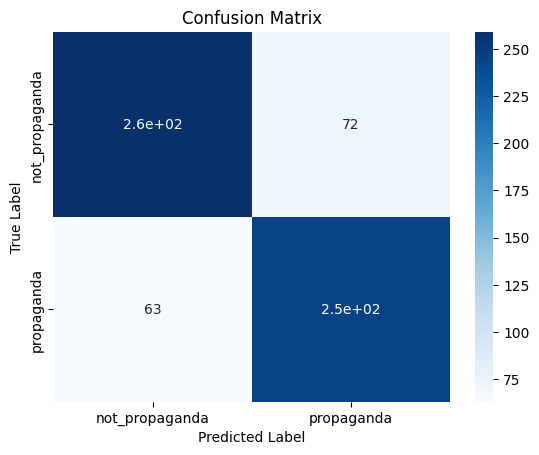

In [ ]:
# Plotting a confusion matrix
cm_bert = confusion_matrix(test_labels, predictions_mlp).astype(int)
sns.heatmap(cm_bert, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# References

1. https://huggingface.co/transformers/v3.3.1/training.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
3. https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
